# Red neuronal recurrente (RNN) GRU vs BiGRU para detección de toxicidad (IsToxic)

En este notebook entrenamos y comparamos dos arquitecturas de redes recurrentes para clasificación binaria de comentarios de YouTube:

Entrenamos los modelos secuenciales:

1. **GRU (Gated Recurrent Unit)** es una variante eficiente de RNN con compuertas que modela dependencias secuenciales en texto de forma eficiente. Ayudan a retener/olvidar información relevante a lo largo de la secuencia, mitigando problemas clásicos como el gradiente que se desvanece.
2. **BiGRU** **(Bidirectional GRU)** procesa cada secuencia en **dos direcciones** (de izquierda a derecha y de derecha a izquierda), capturando más semántica o contexto alrededor de cada palabra, lo que suele ser útil en tareas de lenguaje.

Se comparan seis candidatos (tres para cada modelo) organizados por capacidad y regularización:

### GRU
- `gru_base`
- `gru_mid`
- `gru_reg`

### BiGRU
- `bigru_base`
- `bigru_mid`
- `bigru_reg`

Partimos del dataset limpio:

- Texto: `text_classic` (ubicado en `data/preprocessing_data/youtoxic_english_1000_clean.csv`)
- Etiqueta objetivo principal es: `IsToxic`

## Objetivos
1. Entrenar GRU y BiGRU base.
2. Introducir versiones intermedias (`mid`) para equilibrar capacidad.
3. Introducir versiones regularizadas (`reg`) para mejorar generalización.
4. Evaluar métricas en train y test.
5. Controlar overfitting según rúbrica:
   **F1_train - F1_test ≤ 0.05**.
6. Seleccionar el mejor modelo con la regla del proyecto:
   - Filtrar por gap ≤ 0.05
   - Si hay varios, elegir mayor F1_test
7. Mostrar matriz de confusión y curva AUC-ROC del ganador.
8. Guardar artefacto y JSON estándar compatible con el comparador global:
   - Modelo neuronal: artefacto preferente en `.keras` en `backend/models/`
     (con fallback a **SavedModel export** en Windows si el `.keras` falla).
   - Métricas de resultados en `.json` (formato estándar del equipo) en `data/results/`.

## Nota metodológica
Con datasets pequeños, las RNN pueden:

- **subajustar** si la capacidad es insuficiente.
- **sobreajustar** si la capacidad es alta.

Por eso se emplean variantes base, intermedias y regularizadas.
Además, se incluye un análisis diagnóstico de umbral para interpretar
posibles colapsos de F1 cuando se usa un threshold fijo de 0.5.

Tanto el JSON como el artefacto Keras se usarán directamente en `comparison_models.ipynb`.

> Nota: Usamos TensorFlow y su API de alto nivel `tf.keras`.


### Visualización del Pipeline seguido tanto para GRU como para BiGRU

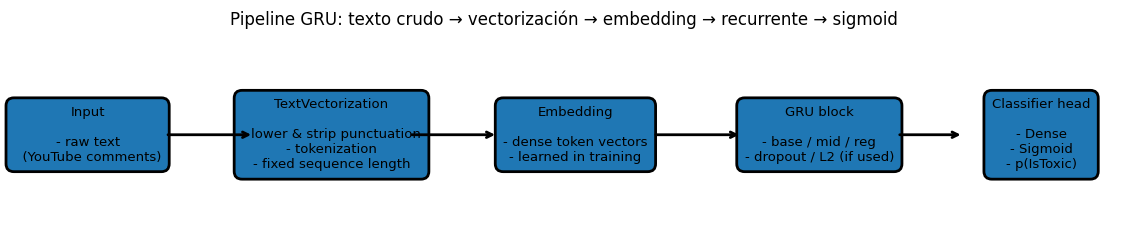

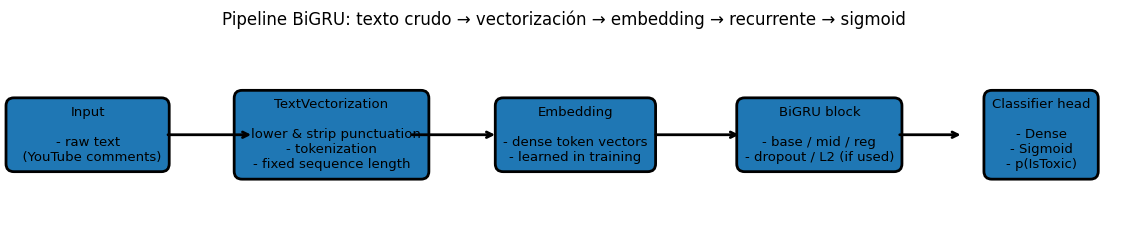


**🔍 Resumen visual del pipeline RNN**

- Partimos de **texto crudo**.
- `TextVectorization` se adapta **solo con train** y queda **integrada** en el modelo.
- `Embedding` aprende representaciones densas de los tokens.
- El bloque **GRU/BiGRU** captura dependencia secuencial.
- La capa final **Dense + Sigmoid** produce `p(IsToxic)`.

Esto deja el artefacto listo para backend sin reconstruir el preprocesado.

✅ Este diseño hace que el artefacto sea autosuficiente:

Si se guarda como .keras, el backend puede cargarlo y enviar texto directamente.
Si en Windows falla el .keras y se genera un *_export/ (SavedModel), el pipeline sigue íntegro y se consume en Keras 3 con TFSMLayer.


In [1]:
# === Visual pipeline diagrams (GRU + BiGRU) ===============================

import matplotlib.pyplot as plt
from IPython.display import Markdown, display


def plot_rnn_pipeline_diagram(arch_label="GRU"):
    """
    Draw a compact visual diagram of the RNN text pipeline.

    raw text -> TextVectorization -> Embedding -> (Bi)GRU -> Dense+Sigmoid
    """
    fig, ax = plt.subplots(figsize=(11.5, 2.4))
    ax.axis("off")

    box_style = dict(boxstyle="round,pad=0.6", linewidth=2)
    arrow_style = dict(arrowstyle="->", linewidth=2)

    # Evenly spaced centers to prevent overlaps
    xs = [0.07, 0.29, 0.51, 0.73, 0.93]
    y = 0.5
    fs = 9.5  # slightly smaller for safety

    # 1) Input
    ax.text(
        xs[0], y,
        "Input\n\n- raw text\n  (YouTube comments)",
        fontsize=fs, va="center", ha="center", bbox=box_style
    )

    # 2) Vectorization
    ax.text(
        xs[1], y,
        "TextVectorization\n\n- lower & strip punctuation\n- tokenization\n- fixed sequence length",
        fontsize=fs, va="center", ha="center", bbox=box_style
    )

    # 3) Embedding
    ax.text(
        xs[2], y,
        "Embedding\n\n- dense token vectors\n- learned in training",
        fontsize=fs, va="center", ha="center", bbox=box_style
    )

    # 4) Recurrent block (kept a bit shorter)
    ax.text(
        xs[3], y,
        f"{arch_label} block\n\n- base / mid / reg\n- dropout / L2 (if used)",
        fontsize=fs, va="center", ha="center", bbox=box_style
    )

    # 5) Output head (more compact to avoid overlap)
    ax.text(
        xs[4], y,
        "Classifier head\n\n- Dense\n- Sigmoid\n- p(IsToxic)",
        fontsize=fs, va="center", ha="center", bbox=box_style
    )

    # Arrows between boxes (center-to-center)
    for i in range(len(xs) - 1):
        ax.annotate(
            "",
            xy=(xs[i + 1] - 0.07, y),
            xytext=(xs[i] + 0.07, y),
            arrowprops=arrow_style
        )

    ax.set_title(
        f"Pipeline {arch_label}: texto crudo → vectorización → embedding → recurrente → sigmoid",
        fontsize=12, pad=18
    )

    plt.tight_layout()
    plt.show()


# --- Render both diagrams ---
plot_rnn_pipeline_diagram("GRU")
plot_rnn_pipeline_diagram("BiGRU")


display(Markdown("""
**🔍 Resumen visual del pipeline RNN**

- Partimos de **texto crudo**.
- `TextVectorization` se adapta **solo con train** y queda **integrada** en el modelo.
- `Embedding` aprende representaciones densas de los tokens.
- El bloque **GRU/BiGRU** captura dependencia secuencial.
- La capa final **Dense + Sigmoid** produce `p(IsToxic)`.

Esto deja el artefacto listo para backend sin reconstruir el preprocesado.
                 
✅ Este diseño hace que el artefacto sea autosuficiente:

Si se guarda como .keras, el backend puede cargarlo y enviar texto directamente.
Si en Windows falla el .keras y se genera un *_export/ (SavedModel), el pipeline sigue íntegro y se consume en Keras 3 con TFSMLayer.
"""))



### 1. Importación de librerías y configuración

En esta celda:

- Importamos:
  - `pandas`, `numpy` para manipulación de datos
  - `tensorflow/keras` para el entrenamiento de la red neuronal
  - `sklearn` para métricas y evaluación
  - `matplotlib` para visulaizaciones homogéneas



In [1]:
# === 1. Import libraries and dependencies ===


# --- Standard library imports for filesystem, JSON IO and reproducibility---

import os                                       # Provides OS-level utilities (paths, environment, etc.)
from pathlib import Path                        # Object-oriented filesystem paths
import json                                     # Read/write structured JSON files for results
from datetime import datetime                   # Create timestamps for experiment tracking
import random                                   # Set Python-level random seeds for reproducibility


# Core scientific stack for data manipulation and numeric operations
import numpy as np                              # Numerical arrays and math utilities
import pandas as pd                             # DataFrame operations for loading and preprocessing

# Deep learning framework (includes Keras high-level API)
import tensorflow as tf                         # Core DL framework; includes tf.keras model/layers API

# --- Keras modules from TensorFlow ---
from tensorflow.keras import layers             # Neural layers (TextVectorization, Embedding, GRU, Dense, Dropout)
from tensorflow.keras import regularizers       # L1/L2 regularization helpers
from tensorflow.keras.callbacks import EarlyStopping  # Early stopping to reduce overfitting

# --- Scikit-learn utilities for splitting and metrics ---
from sklearn.model_selection import train_test_split  # Train/test split with stratification
from sklearn.metrics import (
    accuracy_score,                             # Accuracy metric
    precision_score,                            # Precision metric
    recall_score,                               # Recall metric
    f1_score,                                   # F1-score metric (main rubric focus)
    roc_auc_score,                              # ROC AUC using probabilities
    confusion_matrix,                           # Confusion matrix values
    roc_curve                                   # Coordinates for ROC curve plotting
)

# --- Visualization / notebook display ---
import matplotlib.pyplot as plt                 # Plotting charts
from IPython.display import display, Markdown   # Rich notebook outputs

display(Markdown(
    "✅ **Librerías importadas correctamente.**  \n"
    "Esta celda prepara el entorno para entrenar y evaluar GRU/BiGRU con estilo homogéneo."
))

✅ **Librerías importadas correctamente.**  
Esta celda prepara el entorno para entrenar y evaluar GRU/BiGRU con estilo homogéneo.

## 2. Funciones auxiliares comunes (paths + métricas + overfitting + plots + JSON)

En esta celda reunimos todos los elementos reutilizables del notebook:

Incluye:

- detección robusta de la raíz del proyecto,
- creación de directorios estándar,
- control de reproducibilidad,
- métricas binarias homogéneas,
- chequeo de overfitting según rúbrica,
- visualizaciones en **azul** para matriz de confusión y ROC,
- construcción y guardado del JSON estándar,
- utilidades de entrenamiento y evaluación para Keras.


In [2]:
# === 2. Helper functions (RNN version) =====================================
# This cell provides shared utilities used across the RNN notebook:
# - project path discovery and directory creation
# - reproducibility helpers
# - metric + overfitting rubric helpers
# - plotting utilities
# - standardized JSON builders (compatible with comparison_models.ipynb)
# - lightweight training/evaluation wrappers

# -------------------------
# Project directory helpers
# -------------------------
# These functions allow the notebook to run from different working directories
# without hardcoding local absolute paths.
def rnn_get_project_root():
    """Detect project root by walking up until expected repo folders are found."""
    # We look for a directory that contains both 'data' and 'backend'
    cwd = Path.cwd().resolve()

    for candidate in [cwd, *cwd.parents]:
        backend_ok = (candidate / "backend").exists()
        data_ok = (candidate / "data").exists()
        if backend_ok and data_ok:
            return candidate

    # Fallback to current working directory if structure is not found
    return cwd


def rnn_build_dirs(project_root: Path):
    """Build data, preprocessing, results and models dirs from a detected root."""
    # Standard project folders used by all notebooks and the backend
    data_dir = project_root / "data"
    preproc_dir = data_dir / "preprocessing_data"
    results_dir = data_dir / "results"
    models_dir = project_root / "backend" / "models"

    # Ensure dirs exist for smooth notebook execution
    preproc_dir.mkdir(parents=True, exist_ok=True)
    results_dir.mkdir(parents=True, exist_ok=True)
    models_dir.mkdir(parents=True, exist_ok=True)

    return data_dir, preproc_dir, results_dir, models_dir


# Unified aliases across model notebooks
# These aliases keep a consistent interface with classical model notebooks
# (Naive Bayes, Random Forest) so shared patterns/cells can be reused.
def get_project_root():
    """Alias for rnn_get_project_root to keep a unified interface."""
    return rnn_get_project_root()


def build_project_dirs():
    """Alias for rnn_build_dirs to keep a unified interface."""
    project_root = rnn_get_project_root()
    data_dir, preproc_dir, results_dir, models_dir = rnn_build_dirs(project_root)
    return project_root, data_dir, preproc_dir, results_dir, models_dir


# -------------------------
# Reproducibility helpers
# -------------------------
# This helper is typically called early in the notebook before training.
# Set seeds for reproducibility across Python, NumPy, and TensorFlow
# Note: Full reproducibility may require additional environment settings
def set_global_seed(seed=42):
    """Set seeds across Python, NumPy, and TensorFlow."""
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


# -------------------------
# Metric helpers
# -------------------------
# These functions standardize metric computation across train/test
# and feed the JSON builder used by the global comparator.
def compute_binary_metrics(y_true, y_pred, y_proba):
    """Compute core binary classification metrics used across the project."""
    return {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
        "roc_auc": float(roc_auc_score(y_true, y_proba)) if len(np.unique(y_true)) > 1 else None
    }


def compute_confusion_dict(y_true, y_pred):
    """Return confusion matrix as a dict with tn/fp/fn/tp."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)}


# Overfitting rubric used across the project to keep model selection consistent.
def check_overfitting(train_f1, test_f1, threshold=0.05):
    """Check rubric compliance based on F1 gap."""
    gap = float(train_f1 - test_f1)
    return gap, gap <= threshold


# UI helper to show a human-readable overfitting diagnosis in the notebook.
# The text shown to users remains in Spanish by design for this project.
def display_overfitting_message(f1_gap, threshold=0.05):
    """Render a friendly overfitting message based on F1 gap (RNN version)."""
    if f1_gap > threshold:
        display(Markdown(
            f"⚠️ **Posible overfitting detectado**: "
            f"`F1_train - F1_test = {f1_gap:.3f}` > {threshold}.\n\n"
            "Sugerencias para reducirlo en GRU/BiGRU:\n"
            "- Reducir unidades GRU\n"
            "- Aumentar `Dropout` y `recurrent_dropout`\n"
            "- Añadir regularización `L2`\n"
            "- Reducir dimensión del `Embedding`\n"
            "- Usar `EarlyStopping` más estricto"
        ))
    else:
        display(Markdown(
            f"✅ **Overfitting controlado**: "
            f"`F1_train - F1_test = {f1_gap:.3f}` ≤ {threshold}."
        ))


# -------------------------
# Plot helpers
# -------------------------
# Simple, consistent plotting utilities used for diagnostics.
def plot_confusion_matrix_cm(cm_dict, title="Confusion Matrix"):
    """Plot confusion matrix from a dict structure using a consistent blue style."""
    cm = np.array([
        [cm_dict["tn"], cm_dict["fp"]],
        [cm_dict["fn"], cm_dict["tp"]]
    ])

    fig, ax = plt.subplots(figsize=(4.6, 4.0))
    im = ax.imshow(cm, cmap="Blues")
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Count", rotation=90)

    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["0", "1"])
    ax.set_yticklabels(["0", "1"])

    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")

    plt.tight_layout()
    plt.show()


def plot_roc_curve_simple(y_true, y_proba, title="ROC Curve"):
    """Plot ROC curve with AUC in legend using a consistent blue style."""
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) > 1 else 0.0

    plt.figure(figsize=(5.2, 4.0))
    plt.plot(fpr, tpr, color="tab:blue", label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")

    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(title="Curvas")
    plt.tight_layout()
    plt.show()


# -------------------------
# JSON helpers
# -------------------------
# This builder is the key compatibility layer with comparison_models.ipynb.
# The global comparator expects classic-like blocks:
# - "data"
# - "metrics"
# - plus optional rubric metadata.
# We also keep detailed RNN-specific blocks for transparency.
def build_results_json(
    model_name,
    train_metrics,
    test_metrics,
    cm_dict,
    target_col,
    text_col,
    len_train,
    len_test,
    random_state,
    f1_gap_threshold,
    notes="",
    artifact_type="keras",
    extra_fields=None,
    n_features_text=None,
    n_features_numeric=0,
    metrics_source="test"
):
    """
    Build standardized results dict compatible with the global comparison notebook.

    This version keeps the detailed RNN blocks (train_metrics/test_metrics)
    AND adds a classic-compatible summary structure:
    - data
    - metrics
    - overfitting_control

    The comparison notebook is expected to read 'metrics' and 'data'.
    """

    # Compute rubric gap using the shared helper
    gap_f1, compliant = check_overfitting(
        train_metrics["f1"], test_metrics["f1"], f1_gap_threshold
    )

    # Derived dataset metadata
    n_samples = int(len_train + len_test)
    train_ratio = float(len_train / n_samples) if n_samples else 0.0
    test_ratio = float(len_test / n_samples) if n_samples else 0.0

    # Classic-compatible summary (use test metrics by default)
    summary_metrics = {
        "accuracy": float(test_metrics.get("accuracy", np.nan)),
        "precision": float(test_metrics.get("precision", np.nan)),
        "recall": float(test_metrics.get("recall", np.nan)),
        "f1": float(test_metrics.get("f1", np.nan)),
        "roc_auc": float(test_metrics.get("roc_auc", np.nan))
        if test_metrics.get("roc_auc", None) is not None else None
    }

    results = {
        "model_name": model_name,
        "task": "binary_classification",
        "target_label": target_col,
        "text_column": text_col,

        # ---- Comparator-friendly blocks ----
        "data": {
            "n_samples": n_samples,
            "n_features_text": int(n_features_text) if n_features_text is not None else None,
            "n_features_numeric": int(n_features_numeric),
            "train_size": train_ratio,
            "test_size": test_ratio,
            "random_state": int(random_state)
        },
        "metrics": summary_metrics,
        "metrics_source": metrics_source,

        "confusion_matrix": {
            "tn": int(cm_dict["tn"]),
            "fp": int(cm_dict["fp"]),
            "fn": int(cm_dict["fn"]),
            "tp": int(cm_dict["tp"])
        },

        "overfitting_control": {
            "f1_gap_train_test": float(gap_f1),
            "rubric_threshold": float(f1_gap_threshold),
            "rubric_compliant": bool(compliant)
        },

        # ---- Detailed RNN blocks (kept for transparency) ----
        "train_metrics": train_metrics,
        "test_metrics": test_metrics,
        "f1_gap_train_test": float(gap_f1),
        "rubric_threshold": float(f1_gap_threshold),
        "rubric_compliant": bool(compliant),
        "train_size": int(len_train),
        "test_size": int(len_test),

        "random_state": int(random_state),
        "timestamp": datetime.now().isoformat(),
        "artifact_type": artifact_type,
        "notes": notes
    }

    # Allow optional extra fields without breaking the comparator
    if extra_fields:
        results.update(extra_fields)

    return results


# Small dedicated saver to keep naming conventions consistent.
# Ensures UTF-8 JSON for safe cross-platform usage.
def save_results_json(results_dict, results_dir: Path, model_name: str):
    """Save results JSON using project naming conventions."""
    results_dir.mkdir(parents=True, exist_ok=True)
    path = results_dir / f"{model_name}.json"
    with open(path, "w", encoding="utf-8") as f:
        json.dump(results_dict, f, indent=2, ensure_ascii=False)
    return path


# -------------------------
# Training/Evaluation helpers
# -------------------------
# Lightweight wrappers used to:
# - reduce repetition in the model loop
# - keep training settings consistent across GRU/BiGRU experiments.
def get_early_stopping(monitor="val_loss", patience=3):
    """Factory for EarlyStopping callback with project-friendly defaults."""
    return EarlyStopping(
        monitor=monitor,
        patience=patience,
        restore_best_weights=True
    )


def fit_model(model, X_train, y_train, epochs, batch_size, class_weight=None):
    """Train a Keras model with a validation split and early stopping."""
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[get_early_stopping()],
        class_weight=class_weight,
        verbose=0
    )
    return history


# Standardized evaluation at a fixed threshold (default 0.5) for comparability.
def eval_model(model, X_train, y_train, X_test, y_test, threshold=0.5):
    """Evaluate model on train/test using a fixed threshold."""
    tr_proba = model.predict(X_train, verbose=0).ravel()
    te_proba = model.predict(X_test, verbose=0).ravel()

    tr_pred = (tr_proba >= threshold).astype(int)
    te_pred = (te_proba >= threshold).astype(int)

    train_metrics = compute_binary_metrics(y_train, tr_pred, tr_proba)
    test_metrics = compute_binary_metrics(y_test, te_pred, te_proba)
    cm_dict = compute_confusion_dict(y_test, te_pred)

    return train_metrics, test_metrics, cm_dict, tr_proba, te_proba


display(Markdown(
    "✅ **Helpers RNN cargados.**  \n"
    "Incluye rutas, semillas, métricas, overfitting, plots en azul, JSON y utilidades Keras."
))


✅ **Helpers RNN cargados.**  
Incluye rutas, semillas, métricas, overfitting, plots en azul, JSON y utilidades Keras.

## 3. Configuración global del experimento

Definimos parámetros de:

- partición train/test,
- columnas objetivo,
- vectorización,
- entrenamiento,
- regularización,
- criterio de overfitting,
- naming final de artefactos.


In [3]:
# === 3. Global config =======================================================
# This configuration centralizes all experiment parameters so that:
# - Every candidate is trained/evaluated under the same conditions
# - The notebook remains readable and easy to tune
# - We can trace decisions in the final JSON notes

# -------------------------
# Reproducibility and split
# -------------------------

RANDOM_STATE = 42
# Controls randomness across train/test split and global seeding.
# Used in:
# - set_global_seed(RANDOM_STATE)
# - train_test_split(..., random_state=RANDOM_STATE)

TEST_SIZE = 0.2
# Proportion of the dataset reserved for the test split.
# Used in:
# - train_test_split(..., test_size=TEST_SIZE)

# -------------------------
# Target and text columns
# -------------------------

TARGET_COL = "IsToxic"
# Main binary label for this notebook.
# Used in:
# - dataset column validation
# - y extraction
# - titles and JSON metadata

TEXT_COL = "text_classic"
# Pre-agreed text field for classic + deep models.
# Used in:
# - X extraction
# - JSON metadata

# -------------------------
# TextVectorization params
# -------------------------

MAX_WORDS = 20000
# Maximum vocabulary size for TextVectorization.
# Higher values may improve coverage but increase capacity and overfitting risk.
# Used in:
# - TextVectorization(max_tokens=MAX_WORDS)
# - Embedding(input_dim=MAX_WORDS)

MAX_LEN = 120
# Output sequence length for vectorized text.
# Truncates/pads to a fixed length.
# Used in:
# - TextVectorization(output_sequence_length=MAX_LEN)

# -------------------------
# Training hyperparameters
# -------------------------

EPOCHS = 20
# Maximum number of training epochs.
# EarlyStopping may stop earlier.
# Used in:
# - fit_model(..., epochs=EPOCHS)

BATCH_SIZE = 32
# Mini-batch size used during training.
# Used in:
# - fit_model(..., batch_size=BATCH_SIZE)

# -------------------------
# Rubric / overfitting rule
# -------------------------

F1_GAP_THRESHOLD = 0.05
# Rubric-compliance threshold.
# A model is considered compliant if:
# F1_train - F1_test <= F1_GAP_THRESHOLD
# Used in:
# - check_overfitting(...)
# - selection of best candidate

# -------------------------
# Regularization knobs
# -------------------------

DROPOUT_RATE_BASE = 0.30
# Dropout rate applied after the recurrent block for baseline models.
# Used in:
# - build_gru_base(...)
# - build_bigru_base(...)

DROPOUT_RATE_MID = 0.30
# Dropout rate applied after the recurrent block for mid-capacity models.
# Used in:
# - build_gru_mid(...)
# - build_bigru_mid(...)

DROPOUT_RATE_REG = 0.40
# Stronger dropout for regularized variants.
# Used in:
# - build_gru_reg(...)
# - build_bigru_reg(...)

GRU_DROPOUT = 0.25
# Dropout applied inside the GRU cell (input connections).
# Helps reduce overfitting in small datasets.
# Used in:
# - build_gru_mid(...)
# - build_bigru_mid(...)

GRU_REC_DROPOUT = 0.15
# Dropout applied to the recurrent state transitions.
# Particularly useful for RNNs when the dataset is small.
# Used in:
# - build_gru_mid(...)
# - build_bigru_mid(...)

L2_STRENGTH_MID = 5e-5
# Mild L2 regularization for mid-capacity candidates.
# Penalizes large weights but keeps learning flexibility.
# Used in:
# - kernel_regularizer=regularizers.l2(L2_STRENGTH_MID)

L2_STRENGTH_REG = 1e-4
# Stronger L2 for the most conservative candidates.
# Used in:
# - kernel_regularizer=regularizers.l2(L2_STRENGTH_REG)

# -------------------------
# Naming conventions
# -------------------------

MODEL_NAME_BASE = "rnn_bigru_IsToxic"
# Base name used to build the final artifact and JSON names.
# The final saved names will be:
# - f"{MODEL_NAME_BASE}_{best_tag}.keras"
# - f"{MODEL_NAME_BASE}_{best_tag}.json"
# Used in:
# - final_model_name construction
# - JSON model_name

display(Markdown("✅ **Parámetros globales definidos (con explicación de uso).**"))


✅ **Parámetros globales definidos (con explicación de uso).**

## 4. Carga del dataset limpio (estilo Random Forest)

Detectamos la raíz del proyecto de forma robusta,
construimos directorios estándar y validamos la existencia del CSV limpio.


In [4]:
# === 4. Load clean dataset ==================================================

set_global_seed(RANDOM_STATE)

project_root = rnn_get_project_root()
data_dir, preproc_dir, results_dir, models_dir = rnn_build_dirs(project_root)

print("📂 CWD:", Path.cwd())
print("📁 Raíz del proyecto detectada:", project_root)
print("📂 preproc_dir:", preproc_dir)
print("📂 results_dir:", results_dir)
print("📂 models_dir:", models_dir)

csv_path = preproc_dir / "youtoxic_english_1000_clean.csv"

if not csv_path.exists():
    raise FileNotFoundError(
        "❌ No se encontró el dataset limpio en:\n"
        "   data/preprocessing_data/youtoxic_english_1000_clean.csv"
    )

df = pd.read_csv(csv_path)

display(Markdown(f"""
✅ Dataset cargado correctamente.

- Filas: **{df.shape[0]}**
- Columnas: **{df.shape[1]}**
"""))

required_cols = [TARGET_COL, TEXT_COL]
missing = [c for c in required_cols if c not in df.columns]

if missing:
    raise ValueError(
        "❌ Faltan columnas necesarias en el dataset limpio:\n"
        + "\n".join([f"- {c}" for c in missing])
    )

display(df.head(5))


📂 CWD: c:\dev\proyectos\PX_NLP_G4\backend\notebooks
📁 Raíz del proyecto detectada: C:\dev\proyectos\PX_NLP_G4
📂 preproc_dir: C:\dev\proyectos\PX_NLP_G4\data\preprocessing_data
📂 results_dir: C:\dev\proyectos\PX_NLP_G4\data\results
📂 models_dir: C:\dev\proyectos\PX_NLP_G4\backend\models



✅ Dataset cargado correctamente.

- Filas: **997**
- Columnas: **18**


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsReligiousHate,text_basic,text_classic,text_len_classic,word_count_classic,uppercase_ratio,exclamation_count,hate_words_count
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,If only people would just take a step back and...,people would take step back make case wasnt an...,850,129,0.014121,0,2
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,Law enforcement is not trained to shoot to app...,law enforcement trained shoot apprehend traine...,90,13,0.036232,0,3
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\r\nDont you reckon them 'black lives matter' ...,True,True,False,False,True,False,False,False,Dont you reckon them 'black lives matter' bann...,dont reckon black life matter banner held whit...,252,40,0.002375,0,1
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,There are a very large number of people who do...,large number people like police officer called...,339,49,0.015464,0,0
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,"The Arab dude is absolutely right, he should h...",arab dude absolutely right shot extra time sho...,138,23,0.020576,0,1


## 5. División train/test

Aplicamos separación estratificada para mantener proporción de clases.


In [5]:
# === 5. Train/test split ====================================================

df_work = df[[TEXT_COL, TARGET_COL]].dropna()
X = df_work[TEXT_COL].astype(str).values
y = df_work[TARGET_COL].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

len_train, len_test = len(X_train), len(X_test)

display(Markdown("✅ **Split completado con estratificación.**"))
display(Markdown(f"- Train size: **{len_train}**  \n- Test size: **{len_test}**"))


✅ **Split completado con estratificación.**

- Train size: **797**  
- Test size: **200**

## 6. Distribución de clases

Comprobamos proporción de clase positiva en train y test.

Aunque el dataset global está cerca del equilibrio,
esta verificación es útil en datasets pequeños para entender variabilidad.


In [6]:
# === 6. Class distribution ==================================================

train_pos = float(np.mean(y_train))
test_pos = float(np.mean(y_test))

display(Markdown("📌 **Distribución de clase positiva (IsToxic=1)**"))
display(Markdown(
    f"- Proporción en train: **{train_pos:.3f}**  \n"
    f"- Proporción en test: **{test_pos:.3f}**"
))


📌 **Distribución de clase positiva (IsToxic=1)**

- Proporción en train: **0.460**  
- Proporción en test: **0.460**

## 7. TextVectorization

Creamos y adaptamos el vectorizador **únicamente con datos de train**
para evitar *data leakage* y mantener una evaluación limpia.

El `TextVectorization` se integra **dentro del propio modelo**
para que el artefacto guardado sea **autosuficiente**:

- Si se guarda como `.keras`, el backend podrá cargarlo y enviar texto directamente.
- Si en Windows falla el `.keras` y se genera un `export/SavedModel`,
  el artefacto sigue incluyendo el vectorizador y acepta texto crudo
  (consumible en Keras 3 vía `TFSMLayer`).

De esta forma, el backend **no necesita reconstruir el pipeline de preprocesado**
ni recalcular el vocabulario para inferencia.


In [7]:
# === 7. TextVectorization ===================================================

# TextVectorization layer to turn raw text into integer token sequences.
# This is part of the model's preprocessing pipeline so it can be exported
# together with the network and used directly in production.
vectorizer = layers.TextVectorization(
    # Maximum size of the vocabulary to learn from training data.
    max_tokens=MAX_WORDS,
    # Fixed length for all sequences (padding/truncation applied automatically).
    output_sequence_length=MAX_LEN,
    # Basic normalization: lowercase + strip punctuation.
    standardize="lower_and_strip_punctuation"
)

# IMPORTANT:
# We adapt ONLY on the training split to avoid leaking information
# from validation/test into the learned vocabulary.
vectorizer.adapt(X_train)

# Spanish UI message for consistency with the rest of the notebook.
display(Markdown("✅ **TextVectorization adaptado solo con train.**"))


✅ **TextVectorization adaptado solo con train.**

## 8. Definición de candidatos GRU y BiGRU

Definimos seis arquitecturas organizadas en dos familias y tres niveles de capacidad.
El objetivo es **controlar sistemáticamente la complejidad** para observar su impacto
en un dataset de tamaño limitado.

### GRU
- `gru_base`: baseline estándar como punto de referencia.
- `gru_mid`: capacidad intermedia para reducir riesgo de underfitting.
- `gru_reg`: variante conservadora con regularización para priorizar generalización.

### BiGRU
- `bigru_base`: baseline bidireccional para mayor contexto.
- `bigru_mid`: equilibrio entre capacidad y estabilidad.
- `bigru_reg`: versión regularizada para mitigar sobreajuste.

Este diseño permite analizar de forma ordenada:
- el posible **underfitting** en configuraciones de baja capacidad,
- y el posible **overfitting** en configuraciones más expresivas,
manteniendo una comparación homogénea entre variantes.


In [8]:
# === 8. Define GRU and BiGRU model candidates ===============================
# This section defines six RNN candidates organized by capacity:
# - base: standard baseline
# - mid: intermediate capacity to reduce underfitting/overfitting extremes
# - reg: stronger regularization for safer generalization on small datasets
#
# All models:
# - ingest raw text via tf.string Input
# - apply the shared TextVectorization layer
# - learn word representations with Embedding
# - encode sequences with GRU/BiGRU
# - produce a sigmoid probability for IsToxic

def build_gru_base(vectorizer, max_words):
    """Baseline GRU model."""
    # Input expects a single raw text string per example
    inputs = tf.keras.Input(shape=(1,), dtype=tf.string)

    # TextVectorization converts raw text into integer token ids
    x = vectorizer(inputs)

    # Embedding maps token ids to dense vectors
    # - max_words: vocabulary size (input_dim)
    # - 128: embedding dimensionality
    x = layers.Embedding(max_words, 128)(x)

    # GRU(64):
    # - 64 units define the recurrent capacity of the model
    # - Higher units can improve learning but increase overfitting risk
    x = layers.GRU(64)(x)

    # Dropout after the recurrent block:
    # - DROPOUT_RATE_BASE is a moderate regularization level
    x = layers.Dropout(DROPOUT_RATE_BASE)(x)

    # Sigmoid output for binary classification
    outputs = layers.Dense(1, activation="sigmoid")(x)

    # Build and compile model
    model = tf.keras.Model(inputs, outputs)

    # Adam: robust adaptive optimizer for deep learning
    # Binary crossentropy: standard loss for binary classification with sigmoid
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


def build_gru_mid(vectorizer, max_words):
    """Mid-capacity GRU model to balance learning and generalization."""
    inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
    x = vectorizer(inputs)

    # Same embedding size as base to keep representation capacity
    x = layers.Embedding(max_words, 128)(x)

    # GRU(48):
    # - 48 units reduces capacity vs the base GRU(64)
    # - Intended to reduce overfitting risk while avoiding severe underfitting
    #
    # dropout:
    # - Applies dropout to the input connections inside the GRU cell
    #
    # recurrent_dropout:
    # - Applies dropout to recurrent state transitions
    # - Useful for small datasets to stabilize sequence learning
    #
    # kernel_regularizer (L2):
    # - Penalizes large recurrent weights
    # - Mild strength for mid model
    x = layers.GRU(
        48,
        dropout=GRU_DROPOUT,
        recurrent_dropout=GRU_REC_DROPOUT,
        kernel_regularizer=regularizers.l2(L2_STRENGTH_MID)
    )(x)

    # Dropout after the recurrent block
    x = layers.Dropout(DROPOUT_RATE_MID)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


def build_gru_reg(vectorizer, max_words):
    """Regularized GRU model for improved generalization."""
    inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
    x = vectorizer(inputs)

    # Smaller embedding dimension:
    # - Reduces parameter count and overfitting risk
    x = layers.Embedding(max_words, 96)(x)

    # GRU(32):
    # - Lower capacity for conservative generalization
    #
    # dropout=0.30 and recurrent_dropout=0.20:
    # - Stronger internal regularization vs mid/base
    #
    # L2_STRENGTH_REG:
    # - Stronger L2 penalty for safer learning on small data
    x = layers.GRU(
        32,
        dropout=0.30,
        recurrent_dropout=0.20,
        kernel_regularizer=regularizers.l2(L2_STRENGTH_REG)
    )(x)

    # Stronger post-GRU dropout
    x = layers.Dropout(DROPOUT_RATE_REG)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


def build_bigru_base(vectorizer, max_words):
    """Baseline BiGRU model."""
    inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
    x = vectorizer(inputs)

    # Standard embedding size
    x = layers.Embedding(max_words, 128)(x)

    # Bidirectional wrapper:
    # - Processes the sequence forward and backward
    # - Improves context capture but increases parameters and overfitting risk
    x = layers.Bidirectional(layers.GRU(64))(x)

    x = layers.Dropout(DROPOUT_RATE_BASE)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


def build_bigru_mid(vectorizer, max_words):
    """Mid-capacity BiGRU model to reduce overfitting vs the base BiGRU."""
    inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
    x = vectorizer(inputs)

    x = layers.Embedding(max_words, 128)(x)

    # BiGRU with reduced units (48):
    # - Keeps bidirectional context advantages
    # - Reduces capacity vs BiGRU(64)
    #
    # Using the same internal dropout and mild L2 as GRU mid
    x = layers.Bidirectional(
        layers.GRU(
            48,
            dropout=GRU_DROPOUT,
            recurrent_dropout=GRU_REC_DROPOUT,
            kernel_regularizer=regularizers.l2(L2_STRENGTH_MID)
        )
    )(x)

    x = layers.Dropout(DROPOUT_RATE_MID)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


def build_bigru_reg(vectorizer, max_words):
    """Regularized BiGRU model."""
    inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
    x = vectorizer(inputs)

    # Reduced embedding size to lower parameter count
    x = layers.Embedding(max_words, 96)(x)

    # BiGRU(32) with stronger internal dropout + L2:
    # - A conservative option for small datasets
    x = layers.Bidirectional(
        layers.GRU(
            32,
            dropout=0.30,
            recurrent_dropout=0.20,
            kernel_regularizer=regularizers.l2(L2_STRENGTH_REG)
        )
    )(x)

    x = layers.Dropout(DROPOUT_RATE_REG)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


# Instantiate all candidates using the shared vectorizer and vocabulary size
candidates = {
    "gru_base": build_gru_base(vectorizer, MAX_WORDS),
    "gru_mid": build_gru_mid(vectorizer, MAX_WORDS),
    "gru_reg": build_gru_reg(vectorizer, MAX_WORDS),
    "bigru_base": build_bigru_base(vectorizer, MAX_WORDS),
    "bigru_mid": build_bigru_mid(vectorizer, MAX_WORDS),
    "bigru_reg": build_bigru_reg(vectorizer, MAX_WORDS),
}

display(Markdown("✅ **Candidatos definidos: GRU/BiGRU base-mid-reg.**"))
display(Markdown(
    "Se han creado arquitecturas con distintos niveles de capacidad y regularización "
    "para analizar underfitting/overfitting en un dataset pequeño."
))
display(Markdown(f"- Tags disponibles: `{list(candidates.keys())}`"))


✅ **Candidatos definidos: GRU/BiGRU base-mid-reg.**

Se han creado arquitecturas con distintos niveles de capacidad y regularización para analizar underfitting/overfitting en un dataset pequeño.

- Tags disponibles: `['gru_base', 'gru_mid', 'gru_reg', 'bigru_base', 'bigru_mid', 'bigru_reg']`

## 9. Control opcional por pesos de clase

Aunque el dataset global está cerca del equilibrio, en conjuntos pequeños
las RNN pueden beneficiarse de `class_weight` para estabilizar el aprendizaje
de la clase positiva.

Aplicaremos estos pesos al entrenamiento de todos los candidatos.


In [9]:
# === 9. Class weights =======================================================

neg = int(np.sum(y_train == 0))
pos = int(np.sum(y_train == 1))

if pos == 0:
    raise ValueError("❌ No hay positivos en train. Revisa el split.")

weight_for_0 = 1.0
weight_for_1 = neg / pos

class_weight = {0: weight_for_0, 1: weight_for_1}

display(Markdown("✅ **Class weights calculados.**"))
display(Markdown(
    f"- Negativos (0): **{neg}**  \n"
    f"- Positivos (1): **{pos}**  \n"
    f"- class_weight: **{class_weight}**"
))


✅ **Class weights calculados.**

- Negativos (0): **430**  
- Positivos (1): **367**  
- class_weight: **{0: 1.0, 1: 1.1716621253405994}**

## 10. Entrenamiento y evaluación uniforme

Entrenamos cada candidato usando:

- `fit_model(...)` con `EarlyStopping`,
- `class_weight` calculado (si se desea),
- evaluación homogénea con `eval_model(...)` a **threshold 0.5**
  para mantener comparabilidad global.

Aunque el dataset global no está muy desbalanceado (~46/54),
se mantiene class_weight como medida de estabilidad en un dataset pequeño,
donde la variabilidad del split puede afectar a la clase positiva.

Guardamos resultados en `records`.


In [10]:
# === 10. Train and evaluate each candidate =================================
# This loop trains all candidate models under the same conditions to ensure:
# - Fair comparison across architectures
# - Consistent rubric checking (F1 gap)
# - Compatibility with the global comparison notebook
#
# We store:
# - histories: training histories for optional learning-curve inspection
# - records: structured metrics and objects for later selection and plots

histories = {}
records = []

for tag, model in candidates.items():
    # Train model using shared helper
    # - EPOCHS and BATCH_SIZE come from the global config
    # - class_weight helps stabilize learning even if the dataset is not heavily imbalanced
    #   (especially useful in small datasets)
    history = fit_model(
        model, X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        class_weight=class_weight
    )
    histories[tag] = history

    # Evaluate using the official threshold of 0.5 to keep global comparability
    # This ensures our JSON metrics can be fairly compared with classic models
    train_metrics, test_metrics, cm_dict, tr_proba, te_proba = eval_model(
        model, X_train, y_train, X_test, y_test, threshold=0.5
    )

    # Compute F1 gap for rubric compliance
    gap_f1, compliant = check_overfitting(
        train_metrics["f1"], test_metrics["f1"], F1_GAP_THRESHOLD
    )

    # Store both flat metrics (for tables/plots)
    # and rich objects (for final winner analysis)
    records.append({
        "tag": tag,

        # Flat metrics used in comparison tables and quick plots
        "F1_train": float(train_metrics["f1"]),
        "F1_test": float(test_metrics["f1"]),
        "gap_f1": float(gap_f1),
        "ROC_train": float(train_metrics["roc_auc"]) if train_metrics["roc_auc"] is not None else np.nan,
        "ROC_test": float(test_metrics["roc_auc"]) if test_metrics["roc_auc"] is not None else np.nan,
        "rubric_ok": bool(compliant),

        # Rich objects kept for deeper analysis and final plots
        "model_obj": model,
        "cm_dict": cm_dict,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics,
        "te_proba": te_proba
    })

display(Markdown("✅ **Entrenamiento y evaluación completados para todos los candidatos.**"))
display(Markdown(
    "Las métricas han sido calculadas con threshold=0.5 para mantener "
    "compatibilidad con el comparador global del proyecto."
))
display(Markdown(f"- Candidatos evaluados: **{len(records)}**"))


✅ **Entrenamiento y evaluación completados para todos los candidatos.**

Las métricas han sido calculadas con threshold=0.5 para mantener compatibilidad con el comparador global del proyecto.

- Candidatos evaluados: **6**

## 10.1 Verificación rápida de registros

Comprobamos que todos los candidatos han guardado correctamente
F1/ROC y el gap.


In [11]:
# === 10.1 Debug records =====================================================

debug_df = pd.DataFrame([{
    "tag": r["tag"],
    "F1_train": r["F1_train"],
    "F1_test": r["F1_test"],
    "gap_f1": r["gap_f1"],
    "ROC_train": r["ROC_train"],
    "ROC_test": r["ROC_test"],
    "rubric_ok": r["rubric_ok"]
} for r in records])

display(Markdown("🔍 **Resumen de métricas guardadas en `records`**"))
display(debug_df.round(4))


🔍 **Resumen de métricas guardadas en `records`**

,tag,F1_train,F1_test,gap_f1,ROC_train,ROC_test,rubric_ok
0,gru_base,0.0108,0.0000,0.0108,0.5046,0.4986,True
1,gru_mid,0.0162,0.0000,0.0162,0.5052,0.5031,True
2,gru_reg,0.0162,0.0000,0.0162,0.5127,0.4969,True
3,bigru_base,0.9086,0.6562,0.2524,0.9722,0.7112,False
4,bigru_mid,0.8613,0.6520,0.2094,0.9576,0.7141,False
5,bigru_reg,0.9103,0.6077,0.3026,0.9689,0.7210,False


## 11. Tabla comparativa de candidatos

Ordenamos por:

1. cumplimiento de la rúbrica (`gap ≤ 0.05`),
2. mayor `F1_test` con threshold oficial 0.5.

Esto replica el patrón seguido en otros notebooks, como el del Random Forest.


In [12]:
# === 11. Candidates comparison table =======================================

df_compare = pd.DataFrame([
    {k: v for k, v in r.items()
     if k not in ["model_obj", "cm_dict", "train_metrics", "test_metrics", "te_proba"]}
    for r in records
]).sort_values(["rubric_ok", "F1_test"], ascending=[False, False])

display(Markdown("📊 **Comparativa de candidatos**"))
display(df_compare.round(4))


📊 **Comparativa de candidatos**

,tag,F1_train,F1_test,gap_f1,ROC_train,ROC_test,rubric_ok
0,gru_base,0.0108,0.0000,0.0108,0.5046,0.4986,True
1,gru_mid,0.0162,0.0000,0.0162,0.5052,0.5031,True
2,gru_reg,0.0162,0.0000,0.0162,0.5127,0.4969,True
3,bigru_base,0.9086,0.6562,0.2524,0.9722,0.7112,False
4,bigru_mid,0.8613,0.6520,0.2094,0.9576,0.7141,False
5,bigru_reg,0.9103,0.6077,0.3026,0.9689,0.7210,False


## 11.1 Comparación rápida de candidatos

Mostramos un resumen visual de **F1** y **ROC-AUC** en train/test
para identificar patrones de:

- **underfitting** (métricas bajas en train y test),
- **overfitting** (train alto y test significativamente menor),
- y posibles casos en los que la **rúbrica** pueda favorecer modelos
  con comportamiento **trivial** (por ejemplo, señales débiles en F1 a umbral 0.5).

Separamos la visualización en dos gráficos para facilitar la lectura:

1) **F1** (train vs test)  
2) **ROC-AUC** (train vs test)

Esta comparación rápida sirve como diagnóstico previo antes de aplicar
la selección oficial y la recomendación orientada a producción.


🧪 **Comparación rápida de candidatos RNN (GRU / BiGRU)**

📋 **Resumen compacto (train/test/gap)**

,model,F1_train,F1_test,gap_f1,ROC_train,ROC_test
0,gru_base,0.0108,0.0000,0.0108,0.5046,0.4986
1,gru_mid,0.0162,0.0000,0.0162,0.5052,0.5031
2,gru_reg,0.0162,0.0000,0.0162,0.5127,0.4969
4,bigru_mid,0.8613,0.6520,0.2094,0.9576,0.7141
3,bigru_base,0.9086,0.6562,0.2524,0.9722,0.7112
5,bigru_reg,0.9103,0.6077,0.3026,0.9689,0.7210


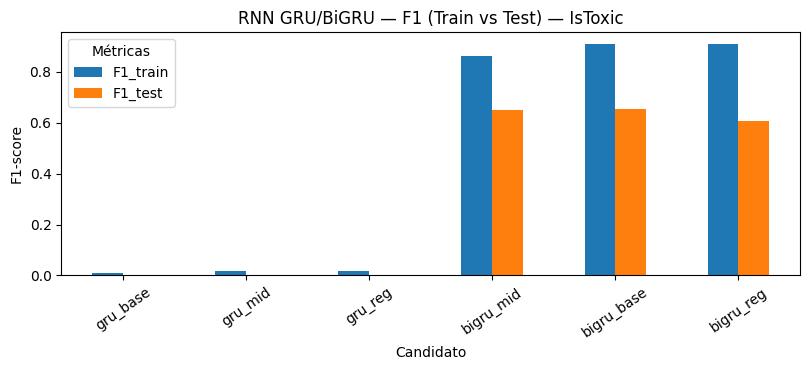

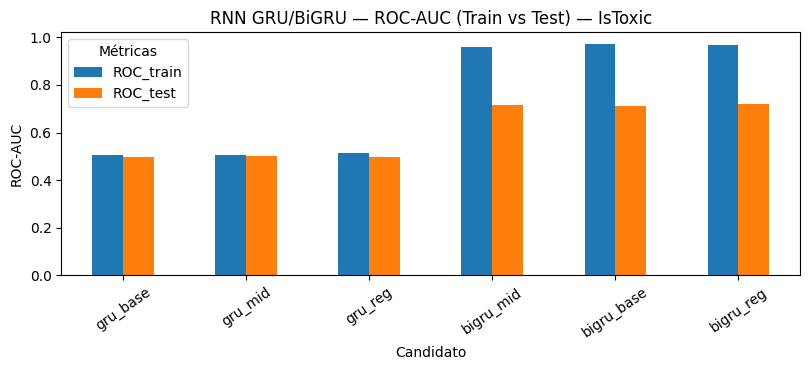


**🔎 Interpretación**

- Los candidatos **GRU** muestran valores de F1 muy cercanos a 0 con el umbral oficial 0.5.
  Esto indica **underfitting** o un comportamiento casi trivial (predicción mayoritaria).
  Por eso las barras de F1_test se ven *pegadas al eje*.

- Los candidatos **BiGRU** muestran:
  - **F1_train alto** y **F1_test alto**, pero con un **gap elevado**.
  Esto sugiere **overfitting** típico en RNN con mayor capacidad y un dataset tan pequeño.

- Con la regla oficial del proyecto (F1 gap ≤ 0.05) ninguno de los candidatos es rubric-compliant:
  - los modelos muy complejos (BiGRU) pueden “perder” por tener gap alto.
  - los modelos muy estables pero malos (GRU) pueden “ganar” por tener gap bajo.
  - por eso añadiremos en la celda 12 un **diagnóstico de umbral**
    y en la celda 13 una **recomendación adicional orientada a producción**.


In [13]:
# === 11.1 Quick candidate comparison (RNN GRU/BiGRU) ========================

display(Markdown("🧪 **Comparación rápida de candidatos RNN (GRU / BiGRU)**"))

# Ensure the comparison table exists
if "df_compare" not in globals() or df_compare is None or df_compare.empty:
    raise ValueError("❌ No existe `df_compare`. Ejecuta antes la celda 11.")

# Build a compact view for plotting
df_quick = df_compare.copy()
df_quick["model"] = df_quick["tag"]
df_quick = df_quick[["model", "F1_train", "F1_test", "gap_f1", "ROC_train", "ROC_test"]]

# Sort to highlight stability first, then test performance
df_quick = df_quick.sort_values(by=["gap_f1", "F1_test"], ascending=[True, False])

display(Markdown("📋 **Resumen compacto (train/test/gap)**"))
display(df_quick.round(4))

# -------------------------
# Plot 1: F1 (Train vs Test)
# -------------------------
plot_f1 = df_quick.set_index("model")[["F1_train", "F1_test"]]

fig, ax = plt.subplots(figsize=(8.2, 3.8))
plot_f1.plot(kind="bar", ax=ax, rot=35)

ax.set_title(f"RNN GRU/BiGRU — F1 (Train vs Test) — {TARGET_COL}")
ax.set_xlabel("Candidato")
ax.set_ylabel("F1-score")
ax.legend(title="Métricas")
plt.tight_layout()
plt.show()

# -------------------------
# Plot 2: ROC-AUC (Train vs Test)
# -------------------------
plot_roc = df_quick.set_index("model")[["ROC_train", "ROC_test"]]

fig, ax = plt.subplots(figsize=(8.2, 3.8))
plot_roc.plot(kind="bar", ax=ax, rot=35)

ax.set_title(f"RNN GRU/BiGRU — ROC-AUC (Train vs Test) — {TARGET_COL}")
ax.set_xlabel("Candidato")
ax.set_ylabel("ROC-AUC")
ax.legend(title="Métricas")
plt.tight_layout()
plt.show()

# Interpretation block in Spanish
display(Markdown(f"""
**🔎 Interpretación**

- Los candidatos **GRU** muestran valores de F1 muy cercanos a 0 con el umbral oficial 0.5.
  Esto indica **underfitting** o un comportamiento casi trivial (predicción mayoritaria).
  Por eso las barras de F1_test se ven *pegadas al eje*.

- Los candidatos **BiGRU** muestran:
  - **F1_train alto** y **F1_test alto**, pero con un **gap elevado**.
  Esto sugiere **overfitting** típico en RNN con mayor capacidad y un dataset tan pequeño.

- Con la regla oficial del proyecto (F1 gap ≤ {F1_GAP_THRESHOLD}) ninguno de los candidatos es rubric-compliant:
  - los modelos muy complejos (BiGRU) pueden “perder” por tener gap alto.
  - los modelos muy estables pero malos (GRU) pueden “ganar” por tener gap bajo.
  - por eso añadiremos en la celda 12 un **diagnóstico de umbral**
    y en la celda 13 una **recomendación adicional orientada a producción**.
"""))


## 12. Diagnóstico de umbral (no afecta al comparador)

Este análisis es **estrictamente diagnóstico**:

- **No modifica** la evaluación oficial (threshold = 0.5).
- **No altera** el JSON estándar que consume `comparison_models.ipynb`.
- Sirve para interpretar candidatos que aparentan bajo rendimiento con 0.5
  pero muestran **señal útil** cuando se exploran umbrales más bajos.

Esto es especialmente relevante en **RNN** con **datasets pequeños**,
donde pequeñas variaciones del split o de la calibración pueden desplazar
el punto óptimo de decisión.

Guardaremos, por cada candidato:

- el **mejor umbral diagnóstico** en test,
- y su **mejor F1 diagnóstico**,

para documentarlo de forma transparente y apoyar,
si procede, una recomendación orientada a producción
sin romper la comparabilidad global del proyecto.


In [14]:
# === 12. Threshold sweep (diagnostic) =======================================

display(Markdown("🧪 **Diagnóstico de umbral para candidatos RNN**"))

# Ensure records exist
if "records" not in globals() or records is None or len(records) == 0:
    raise ValueError("❌ No existe `records`. Ejecuta antes la celda 10.")

# Helper to compute F1 across thresholds
def threshold_sweep(model, X_eval, y_eval, thresholds):
    """Compute F1 across multiple decision thresholds (diagnostic only)."""
    proba = model.predict(X_eval, verbose=0).ravel()
    rows = []

    for t in thresholds:
        pred = (proba >= t).astype(int)
        f1 = f1_score(y_eval, pred, zero_division=0)
        rows.append({"threshold": float(t), "F1_test": float(f1)})

    return pd.DataFrame(rows), proba


thresholds = np.linspace(0.1, 0.9, 9)
diag_rows = []

# Compute and store best diagnostic threshold per candidate
for r in records:
    tag = r["tag"]
    model = r["model_obj"]

    df_thr, te_proba = threshold_sweep(model, X_test, y_test, thresholds)

    best_row = df_thr.sort_values("F1_test", ascending=False).iloc[0]
    best_t = float(best_row["threshold"])
    best_f1 = float(best_row["F1_test"])

    # Store diagnostic fields back into records (safe for later use)
    r["best_threshold_test_diag"] = best_t
    r["best_f1_test_diag"] = best_f1

    # Track predicted positive rates for interpretability
    pos_rate_05 = float((te_proba >= 0.5).mean())
    pos_rate_best = float((te_proba >= best_t).mean())

    r["pos_rate_test_thr_05"] = pos_rate_05
    r["pos_rate_test_best_thr"] = pos_rate_best

    diag_rows.append({
        "tag": tag,
        "best_threshold_test_diag": best_t,
        "best_f1_test_diag": best_f1,
        "F1_test_official_0.5": float(r["F1_test"]),
        "gap_f1_official": float(r["gap_f1"]),
        "ROC_test_official": float(r["ROC_test"]),
        "pos_rate_test_thr_05": pos_rate_05,
        "pos_rate_test_best_thr": pos_rate_best
    })

df_thr_summary = pd.DataFrame(diag_rows).sort_values(
    ["best_f1_test_diag", "ROC_test_official"],
    ascending=[False, False]
)

display(Markdown("📊 **Resumen de umbrales diagnósticos**"))
display(df_thr_summary.round(4))

display(Markdown("""
**🔎 Interpretación**

- Observamos que los candidatos **GRU** pueden mostrar un **F1 diagnóstico alto**
  con umbrales bajos (por ejemplo 0.1–0.3),
  mientras que con el umbral oficial 0.5 su F1 cae a 0.

- Esto indica que:
  - el modelo **sí genera probabilidades informativas**,
    pero **no suficientemente altas** para superar 0.5 de forma consistente.

- Los candidatos **BiGRU**:
  - mantienen F1 razonable incluso con 0.5,
  - y además mejoran con umbrales diagnósticos moderados,
    lo que sugiere mayor capacidad de aprendizaje semántico.

- Este bloque no cambia la comparación global,
  pero será clave para justificar una
  **elección orientada a producción** (ver más abajo en este notebook).
"""))


🧪 **Diagnóstico de umbral para candidatos RNN**

📊 **Resumen de umbrales diagnósticos**

,tag,best_threshold_test_diag,best_f1_test_diag,F1_test_official_0.5,gap_f1_official,ROC_test_official,pos_rate_test_thr_05,pos_rate_test_best_thr
5,bigru_reg,0.3,0.6776,0.6077,0.3026,0.7210,0.445,0.765
3,bigru_base,0.3,0.6721,0.6562,0.2524,0.7112,0.500,0.775
4,bigru_mid,0.4,0.6569,0.6520,0.2094,0.7141,0.675,0.910
1,gru_mid,0.1,0.6301,0.0000,0.0162,0.5031,0.000,1.000
0,gru_base,0.1,0.6301,0.0000,0.0108,0.4986,0.000,1.000
2,gru_reg,0.1,0.6301,0.0000,0.0162,0.4969,0.010,1.000



**🔎 Interpretación**

- Observamos que los candidatos **GRU** pueden mostrar un **F1 diagnóstico alto**
  con umbrales bajos (por ejemplo 0.1–0.3),
  mientras que con el umbral oficial 0.5 su F1 cae a 0.

- Esto indica que:
  - el modelo **sí genera probabilidades informativas**,
    pero **no suficientemente altas** para superar 0.5 de forma consistente.

- Los candidatos **BiGRU**:
  - mantienen F1 razonable incluso con 0.5,
  - y además mejoran con umbrales diagnósticos moderados,
    lo que sugiere mayor capacidad de aprendizaje semántico.

- Este bloque no cambia la comparación global,
  pero será clave para justificar una
  **elección orientada a producción** (ver más abajo en este notebook).


## 13. Selección final del modelo

En esta sección realizamos **dos decisiones complementarias** que responden
a necesidades distintas del proyecto: **comparabilidad global** y **viabilidad de despliegue**.

---

### 1) Ganador oficial del proyecto (para comparación global)

Aplicamos la regla acordada para mantener consistencia con la rúbrica:

1. Conservar candidatos con `gap_f1 ≤ 0.05`.  
2. Si hay varios, elegir el de mayor `F1_test` usando el **umbral oficial 0.5**.

Esta decisión garantiza:

- coherencia con el criterio común del grupo,
- trazabilidad académica,
- y compatibilidad directa con `comparison_models.ipynb`.

---

### 2) Recomendación orientada a producción

En datasets pequeños, un modelo puede cumplir la rúbrica simplemente porque
**no aprende lo suficiente** (underfitting):

- el gap queda pequeño,
- pero el rendimiento en test puede ser pobre.

Por ello añadimos una recomendación complementaria, **sin sustituir** la regla oficial:

- priorizar señal real en test apoyándonos en:
  - `ROC_test` (capacidad de ranking más estable),
  - y el **diagnóstico de umbral** de la celda 12.

Esta segunda decisión sirve para evitar seleccionar un modelo
“trivial” para despliegue, manteniendo intacta la comparabilidad global.


In [15]:
# === 13. Select best candidate =============================================

display(Markdown("🏁 **Selección final: ganador oficial vs recomendado producción**"))

# Ensure records exist
if "records" not in globals() or records is None or len(records) == 0:
    raise ValueError("❌ No existe `records`. Ejecuta antes la celda 10.")

# Build a flat dataframe from records
df_raw = pd.DataFrame(records)

# -------------------------
# 1) Official selection rule
# -------------------------
# The official rule is kept intact for global comparability:
# - First filter by rubric compliance (F1 gap)
# - Then select highest F1_test with threshold=0.5
df_ok = df_raw[df_raw["gap_f1"] <= F1_GAP_THRESHOLD].copy()

if df_ok.empty:
    best_official = df_raw.sort_values(["gap_f1", "F1_test"], ascending=[True, False]).iloc[0]
    official_note = "No candidates met rubric gap. Fallback to smallest gap."
else:
    best_official = df_ok.sort_values(["F1_test"], ascending=False).iloc[0]
    official_note = "Selected best rubric-compliant candidate by official F1_test (thr=0.5)."

BEST_TAG_OFFICIAL = best_official["tag"]

# -------------------------
# 2) Production-minded recommendation
# -------------------------
# To avoid selecting trivial/underfitting models, we add a complementary rule:
# - Require a minimum ROC_test signal whenever possible
# - Rank primarily by diagnostic best F1 (threshold sweep)
# - Use ROC_test as a tiebreaker
# - Prefer smaller gap if still tied
MIN_ROC_TEST_PROD = 0.65

df_prod = df_raw[df_raw["ROC_test"] >= MIN_ROC_TEST_PROD].copy()

# If the filter is too strict for a given run, relax gracefully
if df_prod.empty:
    df_prod = df_raw.copy()
    prod_note = "ROC filter relaxed due to small dataset variability."
else:
    prod_note = "Production recommendation filtered by ROC_test signal."

sort_cols = ["best_f1_test_diag", "ROC_test", "gap_f1"]
best_prod = df_prod.sort_values(sort_cols, ascending=[False, False, True]).iloc[0]

BEST_TAG_PROD = best_prod["tag"]

# -------------------------
# Choose the model for downstream cells
# -------------------------
# We keep both tags for transparency.
# The rest of the notebook (plots + saving) will use the production recommendation.
BEST_TAG = BEST_TAG_PROD

# Build a lookup to retrieve rich objects
record_map = {r["tag"]: r for r in records}

row_off = record_map[BEST_TAG_OFFICIAL]
row_prod = record_map[BEST_TAG_PROD]
row_final = record_map[BEST_TAG]

# Display structured summary
display(Markdown(f"""
✅ **Ganador oficial (regla del proyecto):** `{BEST_TAG_OFFICIAL}`  

- F1_train: **{row_off['F1_train']:.3f}**  
- F1_test (thr=0.5): **{row_off['F1_test']:.3f}**  
- gap_f1: **{row_off['gap_f1']:.3f}**  
- ROC_test: **{row_off['ROC_test']:.3f}**  

📌 *Nota oficial*: {official_note}

---

🛠️ **Recomendación para producción:** `{BEST_TAG_PROD}`  

- F1_train: **{row_prod['F1_train']:.3f}**  
- F1_test (thr=0.5): **{row_prod['F1_test']:.3f}**  
- gap_f1: **{row_prod['gap_f1']:.3f}**  
- ROC_test: **{row_prod['ROC_test']:.3f}**  
- Mejor F1 diagnóstico: **{row_prod.get('best_f1_test_diag', np.nan):.3f}**  
- Umbral diagnóstico: **{row_prod.get('best_threshold_test_diag', np.nan):.2f}**  

📌 *Nota producción*: {prod_note}
"""))

# Interpretive guardrail for underfitting winners
if row_off["F1_test"] < 0.10 and row_off["ROC_test"] < 0.55:
    display(Markdown("""
⚠️ **Interpretación clave**

El ganador oficial presenta un patrón compatible con **underfitting**:

- F1_test muy bajo con threshold 0.5.
- ROC_test cercano a 0.5 (rendimiento casi aleatorio).
- Gap pequeño porque el modelo apenas aprende.

Esto explica por qué puede cumplir la rúbrica:
**no por generalizar bien, sino por falta de señal aprendida.**

Por ello, para el despliegue guardaremos el
**modelo recomendado para producción**.
"""))

# Expose the final objects for downstream cells
best_tag = BEST_TAG
best_model = row_final["model_obj"]
best_train_metrics = row_final["train_metrics"]
best_test_metrics = row_final["test_metrics"]
best_cm_dict = row_final["cm_dict"]
best_te_proba = row_final["te_proba"]

display(Markdown(f"✅ **Modelo que se usará en celdas de evaluación y salvado del modelo ganador (celdas 14 y 15):** `{best_tag}`"))


🏁 **Selección final: ganador oficial vs recomendado producción**


✅ **Ganador oficial (regla del proyecto):** `gru_base`  

- F1_train: **0.011**  
- F1_test (thr=0.5): **0.000**  
- gap_f1: **0.011**  
- ROC_test: **0.499**  

📌 *Nota oficial*: Selected best rubric-compliant candidate by official F1_test (thr=0.5).

---

🛠️ **Recomendación para producción:** `bigru_reg`  

- F1_train: **0.910**  
- F1_test (thr=0.5): **0.608**  
- gap_f1: **0.303**  
- ROC_test: **0.721**  
- Mejor F1 diagnóstico: **0.678**  
- Umbral diagnóstico: **0.30**  

📌 *Nota producción*: Production recommendation filtered by ROC_test signal.



⚠️ **Interpretación clave**

El ganador oficial presenta un patrón compatible con **underfitting**:

- F1_test muy bajo con threshold 0.5.
- ROC_test cercano a 0.5 (rendimiento casi aleatorio).
- Gap pequeño porque el modelo apenas aprende.

Esto explica por qué puede cumplir la rúbrica:
**no por generalizar bien, sino por falta de señal aprendida.**

Por ello, para el despliegue guardaremos el
**modelo recomendado para producción**.


✅ **Modelo que se usará en celdas de evaluación y salvado del modelo ganador (celdas 14 y 15):** `bigru_reg`

## 14. Evaluación visual del ganador

Mostramos una evaluación visual en dos capas:

1) Diagnóstico del **ganador oficial** (criterio de rúbrica).  
2) Diagnóstico del **modelo recomendado para producción**.

El objetivo es hacer explícitas las diferencias entre ambas decisiones,
especialmente en un dataset pequeño donde los patrones pueden ser engañosos.

Esto permite ver con claridad:

- por qué una arquitectura **GRU** puede cumplir la rúbrica
  con un `gap_f1` bajo debido a **underfitting**,
- y por qué una **BiGRU** puede resultar más útil para producción
  al capturar más contexto semántico,
  aunque muestre un gap mayor por su mayor capacidad.

En conjunto, esta sección conecta la selección cuantitativa
con una lectura cualitativa del comportamiento del modelo.


📌 **Evaluación visual: ganador oficial vs recomendado producción**

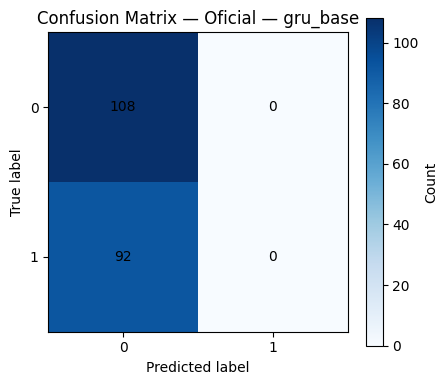

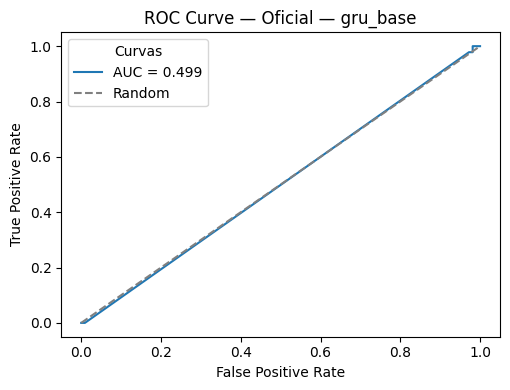

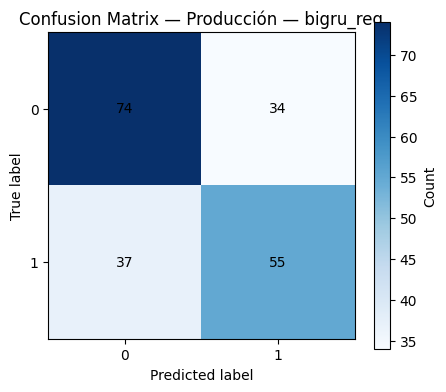

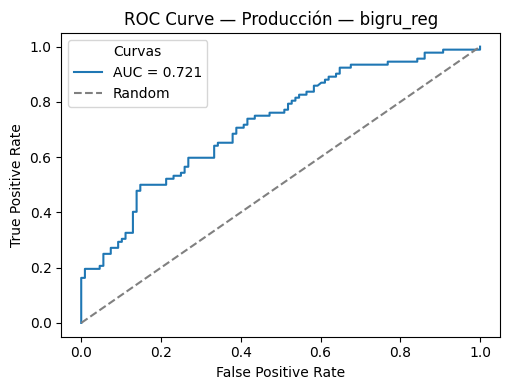


**🔎 Interpretación**

- Si el **ganador oficial** es un GRU con:
  - **F1_test≈0** y **ROC≈0.5**,
  la matriz de confusión suele mostrar:
  - predicción casi exclusiva de la clase 0,
  lo que refleja **underfitting**.

- El **candidato BiGRU recomendado para producción** suele mostrar:
  - una matriz más equilibrada,
  - y una curva ROC por encima del azar,
  indicando aprendizaje más real del patrón tóxico.

- En este dataset pequeño:
  - BiGRU puede presentar gap mayor por capacidad,
  pero ofrece una señal más útil para un modelo productivo.


In [16]:
# === 14. Best candidate plots ==============================================

display(Markdown("📌 **Evaluación visual: ganador oficial vs recomendado producción**"))

# Ensure selection variables exist
if "BEST_TAG_OFFICIAL" not in globals() or "BEST_TAG_PROD" not in globals():
    raise ValueError("❌ Ejecuta antes la celda 13.")

record_map = {r["tag"]: r for r in records}

# Plot official winner
row_off = record_map[BEST_TAG_OFFICIAL]
plot_confusion_matrix_cm(row_off["cm_dict"], title=f"Confusion Matrix — Oficial — {BEST_TAG_OFFICIAL}")
plot_roc_curve_simple(y_test, row_off["te_proba"], title=f"ROC Curve — Oficial — {BEST_TAG_OFFICIAL}")

# Plot production recommendation (if different)
if BEST_TAG_PROD != BEST_TAG_OFFICIAL:
    row_prod = record_map[BEST_TAG_PROD]
    plot_confusion_matrix_cm(row_prod["cm_dict"], title=f"Confusion Matrix — Producción — {BEST_TAG_PROD}")
    plot_roc_curve_simple(y_test, row_prod["te_proba"], title=f"ROC Curve — Producción — {BEST_TAG_PROD}")

display(Markdown("""
**🔎 Interpretación**

- Si el **ganador oficial** es un GRU con:
  - **F1_test≈0** y **ROC≈0.5**,
  la matriz de confusión suele mostrar:
  - predicción casi exclusiva de la clase 0,
  lo que refleja **underfitting**.

- El **candidato BiGRU recomendado para producción** suele mostrar:
  - una matriz más equilibrada,
  - y una curva ROC por encima del azar,
  indicando aprendizaje más real del patrón tóxico.

- En este dataset pequeño:
  - BiGRU puede presentar gap mayor por capacidad,
  pero ofrece una señal más útil para un modelo productivo.
"""))


## 15. Guardado del modelo y JSON final

Guardamos el artefacto **recomendado para producción** y su JSON asociado.

Formato:

- Modelo artefacto Keras en `backend/models/`:
  `rnn_bigru_IsToxic_<best_tag>.keras`

- JSON en `data/results/`:
  `rnn_bigru_IsToxic_<best_tag>.json`

El `model_name` del JSON coincide con el nombre del artefacto,
manteniendo compatibilidad con `comparison_models.ipynb`.

### Nota técnica (Windows + TextVectorización)

En Windows puede ocurrir un error de codificación al guardar `.keras`
si el vocabulario del `TextVectorization` incluye caracteres no soportados
por la codificación local del sistema.

Cuando esto sucede, este notebook aplica un guardado alternativo seguro
en formato **Keras export / TensorFlow SavedModel**:

- Carpeta artefacto en `backend/models/`:
  `rnn_bigru_IsToxic_<best_tag>_export/`

El objetivo es asegurar un modelo autocontenido y cargable en backend
sin reconstrucción manual de arquitectura.

### Carga recomendada en backend (con fallback automático)

```python
from pathlib import Path
import tensorflow as tf

def load_keras_text_model(model_base_path: str):
    """
    Carga un modelo de texto Keras con fallback:
      1) .keras
      2) _export (SavedModel/Keras export)
      3) .h5 (legacy, opcional)
    """
    base = Path(model_base_path)
    candidates = [
        base.with_suffix(".keras"),
        Path(str(base) + "_export"),
        base.with_suffix(".h5"),
    ]
    for p in candidates:
        if p.exists():
            return tf.keras.models.load_model(str(p))
    raise FileNotFoundError("No Keras artifact found for: " + model_base_path)

# Ejemplo:
# model = load_keras_text_model("backend/models/rnn_bigru_IsToxic_bigru_mid")


En todos los casos, el modelo incluye TextVectorization,
por lo que el backend puede recibir texto directamente.



In [17]:
# === 15. Save model and JSON ===============================================

from datetime import datetime
import shutil

display(Markdown("💾 **Guardado del modelo y JSON final (compatible con el comparador)**"))

# Ensure we have a selected production model
if "best_model" not in globals() or "best_tag" not in globals():
    raise ValueError("❌ Ejecuta antes la celda 13.")

final_model_name = f"{MODEL_NAME_BASE}_{best_tag}"

notes = (
    "GRU/BiGRU base-mid-reg with integrated TextVectorization. "
    "Training uses EarlyStopping and class_weight. "
    "Official evaluation at threshold=0.5 for global comparability. "
    "Diagnostic threshold sweep used to support production-minded recommendation. "
    "Windows save strategy: .keras may fail due to TextVectorization vocab encoding; "
    "H5 not reliable with string-preprocessing models; "
    "final fallback uses keras export folder."
)

extra_fields = {
    "best_tag_official": BEST_TAG_OFFICIAL,
    "best_tag_production": BEST_TAG_PROD,
    "production_selection_rule": "max(best_f1_test_diag), tie ROC_test, then smaller gap",
    "best_threshold_test_diag": float(record_map[best_tag].get("best_threshold_test_diag", np.nan)),
    "best_f1_test_diag": float(record_map[best_tag].get("best_f1_test_diag", np.nan)),
    "class_weight_used": class_weight,
}

artifact_type = None
saved_artifact_path = None
save_errors = []

# Paths
keras_path = models_dir / f"{final_model_name}.keras"
export_dir = models_dir / f"{final_model_name}_export"

# -------------------------------------------------------------------------
# 1) Try native single-file .keras (may fail on Windows with TextVectorization)
# -------------------------------------------------------------------------
try:
    best_model.save(keras_path)

    # Validate loadability quickly (defensive)
    _tmp = tf.keras.models.load_model(keras_path)
    _ = _tmp.predict(X_test[:2], verbose=0)

    artifact_type = "keras"
    saved_artifact_path = str(keras_path)

except Exception as e:
    save_errors.append(f".keras save/validation failed: {repr(e)}")
    if keras_path.exists():
        try:
            keras_path.unlink()
        except Exception:
            pass

# -------------------------------------------------------------------------
# 2) Robust fallback: Keras export folder
# -------------------------------------------------------------------------
if artifact_type is None:
    try:
        if export_dir.exists():
            shutil.rmtree(export_dir)

        if hasattr(best_model, "export"):
            best_model.export(str(export_dir))
            artifact_type = "keras_export"
            saved_artifact_path = str(export_dir)
        else:
            # Conservative fallback: Keras-managed directory save
            best_model.save(str(export_dir))
            artifact_type = "savedmodel"
            saved_artifact_path = str(export_dir)

    except Exception as e:
        save_errors.append(f"export/savedmodel failed: {repr(e)}")

# -------------------------------------------------------------------------
# Build JSON
# -------------------------------------------------------------------------
results_dict = build_results_json(
    model_name=final_model_name,
    train_metrics=best_train_metrics,
    test_metrics=best_test_metrics,
    cm_dict=best_cm_dict,
    target_col=TARGET_COL,
    text_col=TEXT_COL,
    len_train=len_train,
    len_test=len_test,
    random_state=RANDOM_STATE,
    f1_gap_threshold=F1_GAP_THRESHOLD,
    notes=notes,
    artifact_type=artifact_type if artifact_type else "unknown",
    extra_fields=extra_fields
)

json_path = save_results_json(results_dict, results_dir, final_model_name)

# -------------------------------------------------------------------------
# User-facing interpretation
# -------------------------------------------------------------------------
if artifact_type is None:
    display(Markdown(
        "❌ **No se pudo guardar el modelo en un formato usable.**  \n"
        "Se ha guardado el JSON para mantener el registro del experimento."
    ))
else:
    display(Markdown(f"""
✅ **Guardado completado.**

- **Modelo seleccionado para producción:** `{best_tag}`
- **Nombre final del experimento:** `{final_model_name}`
- **Formato del artefacto:** `{artifact_type}`
- **Ruta del artefacto:** `{saved_artifact_path}`
- **JSON (compatible con comparison_models.ipynb):** `{json_path}`

📌 **Interpretación**
En este RNN hay `TextVectorization` integrado (entrada `tf.string`).  
En Windows, el guardado **`.keras` puede fallar** por problemas de encoding del vocabulario (emojis).  
El formato **`.h5` no es fiable** con modelos que incluyen preprocessing de texto dentro del grafo.

✅ **Solución estable para backend:**
- Si el formato es **`keras_export`**/**`savedmodel`**, carga apuntando a la carpeta:
  - `tf.keras.models.load_model(r".../{final_model_name}_export")`

Este artefacto es válido para producción y mantiene la vectorización integrada,
por lo que puedes enviar texto directamente.
"""))

if save_errors:
    display(Markdown(
        "⚠️ **Notas técnicas de guardado (primeros errores detectados, p.ej: emojis):**  \n" +
        "\n".join([f"- {msg}" for msg in save_errors[:3]])
    ))


display(Markdown(f"""
✅ **Carga recomendada en backend (con fallback automático):**

```python
from pathlib import Path
import tensorflow as tf

def load_keras_text_model(model_base_path: str):
    base = Path(model_base_path)
    candidates = [
        base.with_suffix(".keras"),
        Path(str(base) + "_export"),
        base.with_suffix(".h5"),
    ]
    for p in candidates:
        if p.exists():
            return tf.keras.models.load_model(str(p))
    raise FileNotFoundError("No Keras artifact found for: " + model_base_path)

model = load_keras_text_model(r"{models_dir / final_model_name}")

En Windows, .keras puede fallar con TextVectorization por encoding del vocabulario.
Por eso este notebook usa keras_export como salida estable cuando es necesario.
"""))

💾 **Guardado del modelo y JSON final (compatible con el comparador)**

INFO:tensorflow:Assets written to: C:\dev\proyectos\PX_NLP_G4\backend\models\rnn_bigru_IsToxic_bigru_reg_export\assets


INFO:tensorflow:Assets written to: C:\dev\proyectos\PX_NLP_G4\backend\models\rnn_bigru_IsToxic_bigru_reg_export\assets


Saved artifact at 'C:\dev\proyectos\PX_NLP_G4\backend\models\rnn_bigru_IsToxic_bigru_reg_export'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.string, name='keras_tensor_30')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2419221108240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2419221107664: TensorSpec(shape=(), dtype=tf.int64, name=None)
  2419221103440: TensorSpec(shape=(), dtype=tf.string, name=None)
  2419221103632: TensorSpec(shape=(), dtype=tf.int64, name=None)
  2419296228304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2419296228112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2419296230800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2419296229456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2419296226960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2419296229264: TensorSpec(shape=(), dtype=tf.resource, nam


✅ **Guardado completado.**

- **Modelo seleccionado para producción:** `bigru_reg`
- **Nombre final del experimento:** `rnn_bigru_IsToxic_bigru_reg`
- **Formato del artefacto:** `keras_export`
- **Ruta del artefacto:** `C:\dev\proyectos\PX_NLP_G4\backend\models\rnn_bigru_IsToxic_bigru_reg_export`
- **JSON (compatible con comparison_models.ipynb):** `C:\dev\proyectos\PX_NLP_G4\data\results\rnn_bigru_IsToxic_bigru_reg.json`

📌 **Interpretación**
En este RNN hay `TextVectorization` integrado (entrada `tf.string`).  
En Windows, el guardado **`.keras` puede fallar** por problemas de encoding del vocabulario (emojis).  
El formato **`.h5` no es fiable** con modelos que incluyen preprocessing de texto dentro del grafo.

✅ **Solución estable para backend:**
- Si el formato es **`keras_export`**/**`savedmodel`**, carga apuntando a la carpeta:
  - `tf.keras.models.load_model(r".../rnn_bigru_IsToxic_bigru_reg_export")`

Este artefacto es válido para producción y mantiene la vectorización integrada,
por lo que puedes enviar texto directamente.


⚠️ **Notas técnicas de guardado (primeros errores detectados, p.ej: emojis):**  
- .keras save/validation failed: UnicodeEncodeError('charmap', '\r\n[UNK]\r\nblack\r\npeople\r\nget\r\npolice\r\nwhite\r\ncop\r\nlike\r\nwould\r\nbrown\r\nofficer\r\nshot\r\ndont\r\none\r\nvideo\r\ntime\r\nknow\r\nsay\r\nracist\r\nman\r\nlife\r\ngo\r\nneed\r\nguy\r\nright\r\nmake\r\nfuck\r\nthink\r\nback\r\nthing\r\nrace\r\nu\r\nshit\r\ngun\r\nwant\r\ngood\r\neven\r\nsee\r\nmatter\r\ngoing\r\nfact\r\ntake\r\nmike\r\nway\r\nshoot\r\nim\r\ngot\r\nferguson\r\nstore\r\nnothing\r\ncommunity\r\nthug\r\nstill\r\nlook\r\nlet\r\nstupid\r\nreally\r\njob\r\nkid\r\nhand\r\ncriminal\r\ntruth\r\nmuch\r\nmichael\r\nfucking\r\nthank\r\nstop\r\nsaying\r\nrun\r\nstreet\r\nsomeone\r\nevery\r\ndidnt\r\nday\r\ncome\r\ncar\r\nwilson\r\nlaw\r\ncould\r\nalso\r\nput\r\nmedium\r\nkilled\r\nissue\r\ncant\r\namerican\r\nriot\r\nprotest\r\ncase\r\nyear\r\nthats\r\nstefan\r\nlove\r\nas\r\nwell\r\ntell\r\nuse\r\nsaid\r\npeggy\r\nmr\r\ncare\r\namerica\r\nstart\r\nprotester\r\nmany\r\nidiot\r\ngetting\r\neveryone\r\ncountry\r\ncnn\r\nworld\r\nwoman\r\nperson\r\nhate\r\ngreat\r\ngod\r\ncall\r\naway\r\nwrong\r\nwork\r\nmaybe\r\nlol\r\nkill\r\nanyone\r\nyoure\r\ntrying\r\nsomething\r\nshow\r\nshooting\r\npoint\r\nnews\r\nhuman\r\nhe\r\nhappened\r\ndeath\r\ncrime\r\nbitch\r\nbelieve\r\nbad\r\nweapon\r\nsupport\r\nstory\r\nsituation\r\nself\r\nplease\r\nkilling\r\nhope\r\nhappen\r\nexcuse\r\nbetter\r\nanything\r\nalways\r\nwitness\r\nviolence\r\nside\r\nreal\r\nrap\r\nproblem\r\nmean\r\nmade\r\nlive\r\njustice\r\nfire\r\ndead\r\ncomment\r\ncause\r\nbig\r\nunderstand\r\nstate\r\nreason\r\nracism\r\nnever\r\nkeep\r\ngive\r\nfind\r\nfamily\r\nanother\r\nact\r\nwithout\r\nwhole\r\ntry\r\nseems\r\nmolyneux\r\nlooting\r\nlittle\r\nhigh\r\ncity\r\nburn\r\naround\r\nactually\r\naction\r\nthought\r\nsure\r\nrespect\r\nreport\r\nran\r\nquestion\r\nprobably\r\npiece\r\nmoney\r\nisnt\r\ninnocent\r\ngang\r\nfirst\r\nevidence\r\ndrug\r\ndoesnt\r\nchild\r\nbody\r\nassaulted\r\nagree\r\nyoung\r\nwonder\r\nwish\r\ntalk\r\nspeak\r\npublic\r\npretty\r\npeace\r\npart\r\nnew\r\nmust\r\nmasri\r\nmartin\r\nmaking\r\nmajority\r\nhead\r\neverything\r\ndumb\r\nbunch\r\nblocking\r\nyet\r\ntwo\r\nthough\r\nracial\r\nmurder\r\nlot\r\nignorant\r\nhubbard\r\nhome\r\nhit\r\nhard\r\ngovernment\r\nenough\r\nelse\r\ncigar\r\nbullshit\r\nboy\r\nbest\r\nattack\r\nalready\r\nafrican\r\nwent\r\nwait\r\nviolent\r\ntruly\r\nschool\r\nrobbery\r\nroad\r\nprotesting\r\nplay\r\nold\r\noh\r\nnice\r\nmove\r\nlost\r\nlean\r\njury\r\njail\r\nincident\r\nguess\r\ngirl\r\ngas\r\nfree\r\never\r\nevent\r\neither\r\ndie\r\ndarren\r\nculture\r\nbrutality\r\nbring\r\narrested\r\narm\r\nyall\r\nword\r\nwatch\r\nused\r\nturn\r\ntraffic\r\ntheyre\r\nthere\r\nsteal\r\nrioting\r\npot\r\npopulation\r\nplace\r\nparent\r\nowner\r\nnigga\r\nnational\r\nname\r\nmicheal\r\nmb\r\nlong\r\ninformation\r\nfear\r\ndude\r\ndriver\r\ndone\r\ndefend\r\ncunt\r\ncolor\r\ncame\r\nbassem\r\nask\r\narrest\r\narea\r\nyes\r\nwouldnt\r\nworse\r\nwont\r\nwanna\r\nview\r\nusa\r\nunarmed\r\ntown\r\ntold\r\ntired\r\ntear\r\ntaken\r\nstuff\r\nstopped\r\nstole\r\nstand\r\nskittle\r\nsince\r\nseen\r\nsaw\r\nsad\r\nrobbed\r\nrest\r\npeaceful\r\npant\r\nnext\r\nmother\r\nmiddle\r\nmen\r\nliving\r\nlisten\r\njoe\r\ninstead\r\nhowever\r\nfull\r\nfriend\r\nforce\r\nfeel\r\nfar\r\nfair\r\nface\r\netc\r\nenforcement\r\nend\r\ndepartment\r\ndangerous\r\ndamn\r\ncourse\r\ncouldnt\r\ncoming\r\ncitizen\r\ncaught\r\ncannot\r\nbusiness\r\nburning\r\nbullet\r\nbehind\r\nattacking\r\nalmost\r\nyoutube\r\nwow\r\nvote\r\nvoice\r\nusing\r\ntype\r\ntreated\r\ntalking\r\nsystem\r\nstrong\r\nstealing\r\nstarted\r\nson\r\nset\r\nseriously\r\nsense\r\nsecond\r\nraise\r\nprotestors\r\npost\r\npoor\r\npd\r\nothers\r\nopinion\r\nok\r\nmusic\r\nmarijuana\r\nlethal\r\nless\r\nlady\r\nkind\r\nid\r\nheard\r\nground\r\ngrand\r\ngiven\r\nfolk\r\nfired\r\nfine\r\nfighting\r\nexactly\r\ndeserve\r\ndeal\r\nconsequence\r\nclearly\r\ncharge\r\nchange\r\ncalled\r\nblock\r\nbeat\r\nb\r\nass\r\narmed\r\narent\r\nanswer\r\nanimal\r\nair\r\nyeah\r\nya\r\nworking\r\nworker\r\nwatching\r\nwasnt\r\nwar\r\nwanted\r\nwalking\r\nvid\r\nvictim\r\nuseless\r\ntrial\r\ntrayvon\r\nthanks\r\nteenager\r\nteen\r\nstep\r\nstatistic\r\nstatement\r\nsorry\r\nsmoking\r\nskin\r\nsingle\r\nsimple\r\nsign\r\nsick\r\nshouldnt\r\nseem\r\nseeing\r\nsearched\r\nrob\r\nridiculous\r\nrapping\r\npresident\r\nppl\r\npower\r\npicture\r\npepper\r\nopen\r\nofficial\r\nobviously\r\nnon\r\nneighborhood\r\nmention\r\nlyric\r\nloot\r\nlmao\r\nlikely\r\nlie\r\nleave\r\nlater\r\nlast\r\nlack\r\nknew\r\njustify\r\ninteresting\r\ninjury\r\nignorance\r\nhouse\r\nhonestly\r\nhistory\r\nhelp\r\nhell\r\nheld\r\nhear\r\nhalf\r\ngroup\r\ngiant\r\ngentle\r\nfound\r\nfoot\r\nfight\r\neye\r\nentire\r\ndrive\r\ndevil\r\ndestroy\r\ndecision\r\ncreated\r\ncrap\r\ncouple\r\ncompletely\r\ncomplete\r\ncollege\r\nclass\r\nchief\r\ncamera\r\nbuy\r\nblunt\r\nbless\r\nattacked\r\narab\r\napprehend\r\naccount\r\nabsolutely\r\nweek\r\nweed\r\nwake\r\nunderstanding\r\ntwice\r\ntried\r\ntrained\r\ntowards\r\ntogether\r\ntea\r\ntaser\r\nstraight\r\nstated\r\nspray\r\nspeaking\r\nsociety\r\nsmoke\r\nsmerconish\r\nsix\r\nshowed\r\nsection\r\nrubber\r\nround\r\nroll\r\nrole\r\nrogan\r\nrioter\r\nresearch\r\nrecord\r\nrealize\r\nrather\r\nrate\r\nrange\r\nquality\r\nprove\r\nprison\r\nomg\r\noffice\r\nneeded\r\nn\r\nmuslim\r\nmouth\r\nmostly\r\nmoron\r\nmight\r\nmentioned\r\nmad\r\nlooking\r\nlight\r\nliberal\r\nlearn\r\nlead\r\njustified\r\nive\r\nisi\r\ninterview\r\ninfo\r\nillegal\r\nill\r\nhuge\r\nhold\r\nhey\r\nhero\r\nhappens\r\nhandle\r\ngiving\r\nghetto\r\ngentleman\r\ngeneration\r\ngarbage\r\nfucker\r\nfront\r\nfreeway\r\nfocus\r\nfinally\r\nfast\r\nfailed\r\nextremely\r\nexplain\r\nencounter\r\nelected\r\neasy\r\ndue\r\ndeserved\r\ndemocrat\r\ncrazy\r\ncommit\r\nclear\r\ncivilian\r\nchildish\r\ncharged\r\nbtw\r\nbrought\r\nblm\r\nbias\r\nbet\r\nbehavior\r\nbecome\r\nauthority\r\namen\r\nallowed\r\nable\r\nwound\r\nwhether\r\nwhats\r\nvoted\r\nupset\r\nunless\r\nunited\r\nunfortunately\r\ntv\r\ntitle\r\nthinking\r\ntest\r\nten\r\ntelling\r\ntaking\r\nsword\r\nsuspect\r\nsurrendering\r\nsupposed\r\nsue\r\nstay\r\nstanding\r\nst\r\nspread\r\nsmh\r\nsmart\r\nsit\r\nsister\r\nsir\r\nsimply\r\nshare\r\nshame\r\nsearch\r\nscene\r\nrunning\r\nrobbing\r\nrevolution\r\nresult\r\nrepresent\r\nreporter\r\nreported\r\nremember\r\nreleased\r\nrecording\r\nready\r\nreaction\r\nreach\r\nraised\r\nquick\r\nputting\r\npussy\r\npunk\r\npull\r\nprotect\r\nproperty\r\npropaganda\r\npresented\r\npolitical\r\npoliceman\r\nplus\r\npast\r\norder\r\nopportunity\r\nobama\r\nnumber\r\nnobody\r\nnegative\r\nminute\r\nminority\r\nmind\r\nmilitary\r\nmessage\r\nmess\r\nmember\r\nmassive\r\nmale\r\nm\r\nlying\r\nlower\r\nlouis\r\nloser\r\nlonger\r\nlistening\r\nline\r\nlevel\r\nletting\r\nlegal\r\nleft\r\nleast\r\nleader\r\nlazy\r\nkkk\r\nking\r\njudge\r\njoke\r\ninvestigation\r\nintelligence\r\ninside\r\ninequality\r\nincome\r\nidea\r\nhour\r\nhide\r\nheart\r\nhat\r\nhandling\r\nha\r\nguilty\r\ngovt\r\ngotta\r\ngonna\r\nglad\r\ngame\r\ngain\r\nfun\r\nft\r\nfreedom\r\nform\r\nfederal\r\nfather\r\nexpect\r\neducation\r\nearth\r\ndoubt\r\ndoor\r\ndon’t\r\ndivide\r\ndifferent\r\ndifference\r\ndied\r\ndeserves\r\ndefense\r\ndear\r\ncry\r\ncorrupt\r\ncorrect\r\nconvenience\r\ncontrol\r\ncommon\r\nclose\r\nclerk\r\nclean\r\nclaim\r\ncharging\r\ncaused\r\ncard\r\ncalling\r\nbreak\r\nblunts\r\nbit\r\nbigger\r\nbiased\r\nbeating\r\nbased\r\nbag\r\nbackup\r\nawesome\r\nautopsy\r\nasked\r\nargument\r\nanger\r\nalong\r\nal\r\naffect\r\nadd\r\nactual\r\naccountable\r\nabuse\r\n–\r\nzimmerman\r\nyea\r\nwtf\r\nwritten\r\nwouldve\r\nworthless\r\nworry\r\nwilling\r\nwhatever\r\nwear\r\nweak\r\nwasting\r\nwalk\r\nvice\r\nvehicle\r\nvalue\r\nutah\r\nupon\r\nunbiased\r\nturned\r\ntrusted\r\ntrump\r\ntrue\r\ntreating\r\ntraining\r\ntragedy\r\ntotally\r\ntip\r\ntill\r\ntie\r\nthus\r\nthumb\r\nthreat\r\ntheyd\r\nthee\r\ntha\r\nterrorist\r\nsupporter\r\nsuperior\r\nsuicide\r\nsuck\r\nstyle\r\nstef\r\nstats\r\nstarting\r\nspitting\r\nspirit\r\nsoundcloud\r\nsound\r\nsize\r\nshut\r\nshowing\r\nservice\r\nserved\r\nserve\r\nsent\r\nsecret\r\nrush\r\nrock\r\nresponsibility\r\nresponse\r\nreciting\r\nreasonable\r\nreality\r\nreacted\r\nrat\r\nrapper\r\npulled\r\nprofessional\r\nprivate\r\nprevious\r\npress\r\npresentation\r\npowerful\r\npound\r\npotential\r\npositive\r\nposition\r\npolitician\r\npointing\r\nplaying\r\nplain\r\npissed\r\nperiod\r\nperhaps\r\nperfectly\r\npay\r\npathetic\r\nparty\r\nparticular\r\npaid\r\noccurred\r\nnotice\r\nnonsense\r\nnone\r\nnegro\r\nnation\r\nnarrative\r\nmurdered\r\nmodel\r\nmo\r\nmlk\r\nmistake\r\nmin\r\nmilitarized\r\nmentality\r\nmay\r\nmanner\r\nmainstream\r\nmagic\r\nluther\r\nlow\r\nlose\r\nlooked\r\nlocal\r\nleadership\r\nlanguage\r\nkiller\r\nkept\r\njr\r\njournalist\r\nintelligent\r\ninformed\r\nindividual\r\nindeed\r\nincluding\r\nimportant\r\nhurting\r\nhurt\r\nhot\r\nhospital\r\nhop\r\nhood\r\nhonest\r\nhilarious\r\nhighly\r\nhed\r\nhappening\r\nhamster\r\nguard\r\ngeneva\r\nfuckin\r\nfucked\r\nfool\r\nfollowing\r\nfinger\r\nfelony\r\nfellow\r\nfed\r\nfake\r\nexplained\r\nexecuted\r\nexcessive\r\nexcept\r\nexcellent\r\nevil\r\neventually\r\nescalation\r\neric\r\nemotion\r\nelitist\r\neffect\r\neasily\r\ndumbass\r\ndress\r\ndouble\r\ndollar\r\ndisease\r\ndiscussion\r\ndirty\r\ndestroying\r\ndestroyed\r\ndefending\r\ndecade\r\ndealing\r\ndeadly\r\ndamage\r\ncourt\r\ncounty\r\ncouncil\r\ncost\r\ncorruption\r\nconvention\r\ncontinue\r\nconstruction\r\nconsistent\r\nconsidering\r\nconsidered\r\nconservative\r\nclue\r\nchose\r\nchoice\r\ncharacter\r\nchannel\r\ncertainly\r\ncausing\r\nbrick\r\nblame\r\nbelief\r\nbeginning\r\nbastard\r\nbaiting\r\nbadge\r\nbaby\r\naware\r\naudio\r\nattention\r\nassume\r\nasshole\r\nassaulting\r\nassault\r\nasian\r\napparently\r\napologize\r\nanyway\r\nanymore\r\nangel\r\nanalysis\r\namount\r\nallegedly\r\nalive\r\naint\r\nago\r\nadult\r\nadmit\r\naddress\r\naddition\r\nactivity\r\nacting\r\naccording\r\nzionist\r\nzimmermans\r\nyouve\r\nyoull\r\nyo\r\nyelling\r\nwriting\r\nwould’ve\r\nworked\r\nwolf\r\nwitnessed\r\nwinning\r\nwinner\r\nwing\r\nwide\r\nwhose\r\nwho\r\nwelfare\r\nwearing\r\nwater\r\nwatched\r\nwarrant\r\nwall\r\nvoter\r\nvile\r\nversion\r\nvaluable\r\nv\r\nur\r\nunfortunate\r\nunemployed\r\nunderstood\r\nugly\r\ntuned\r\ntube\r\ntryvon\r\ntrust\r\ntruck\r\ntrouble\r\ntrevon\r\ntreat\r\ntrash\r\ntoxicology\r\ntough\r\ntouch\r\ntook\r\ntoday\r\ntied\r\nthrowing\r\nthree\r\nthreatening\r\nthreaten\r\nthier\r\ntheyve\r\ntherefore\r\ntheory\r\nthankful\r\ntesttube\r\ntendency\r\ntend\r\nteam\r\ntaught\r\ntakin\r\nsystemic\r\nsymptom\r\nswisher\r\nsweet\r\nsurrender\r\nsuggesting\r\nsubject\r\nstupidity\r\nstolen\r\nstepping\r\nstephan\r\nstating\r\nstaten\r\nstandard\r\nspring\r\nspot\r\nspin\r\nspeech\r\nspeculation\r\nspecial\r\nspeaks\r\nsource\r\nsong\r\nsomewhere\r\nsometimes\r\nsomebody\r\nsoldier\r\nsocial\r\nsnow\r\nsmoked\r\nsmall\r\nslug\r\nslow\r\nskill\r\nsitting\r\nsimilar\r\nsided\r\nshout\r\nshoplifting\r\nshop\r\nshooter\r\nshocking\r\nshirt\r\nshes\r\nsheep\r\nsharpton\r\nsharing\r\nsexually\r\nseveral\r\nserving\r\nserious\r\nsentence\r\nsend\r\nselling\r\nselfish\r\nseek\r\nsecondly\r\nscrew\r\nscreen\r\nscreaming\r\nsatisfying\r\nsaratoga\r\nsane\r\nsafe\r\nrule\r\nruin\r\nroadway\r\nrise\r\nrioted\r\nrightits\r\nrich\r\nrevolutionary\r\nretard\r\nresident\r\nresearcher\r\nrepeated\r\nremain\r\nregion\r\nregardless\r\nregarding\r\nregard\r\nrational\r\nrapped\r\nrant\r\nrancher\r\nram\r\nrally\r\nrage\r\nquestioning\r\nquestionable\r\npunch\r\nprovocateur\r\nproving\r\nprovide\r\nprotection\r\nprotecting\r\nproper\r\nproof\r\nprofiling\r\nproductive\r\nprocess\r\npride\r\nprick\r\nprice\r\npretend\r\nprejudice\r\npoverty\r\nposted\r\npossible\r\npossibility\r\npolicy\r\nplow\r\nplayer\r\nplate\r\nplant\r\nplane\r\nplan\r\npiss\r\npig\r\npick\r\nphoto\r\nphone\r\nphilosophy\r\npetition\r\nperspective\r\nperfect\r\npercent\r\npeer\r\npatter\r\npaper\r\noutta\r\noutside\r\noutraged\r\notherwise\r\noppression\r\noperates\r\nonline\r\nolder\r\nol\r\nokay\r\noj\r\noften\r\noffense\r\noffended\r\nobvious\r\nobject\r\nnurse\r\nnumbered\r\nnormal\r\nnonwhites\r\nnonlethal\r\nnit\r\nnight\r\nnetwork\r\nnecessarily\r\nnd\r\nnavy\r\nmultiple\r\nmoving\r\nmovie\r\nmovement\r\nmothafuckin\r\nmonkey\r\nmoment\r\nmom\r\nmob\r\nmj\r\nmissing\r\nmisleading\r\nmisbehaving\r\nmfer\r\nmet\r\nmemory\r\nmayor\r\nmatrix\r\nmass\r\nmajor\r\nmain\r\nmachine\r\nmace\r\nlooted\r\nlogic\r\nlmfao\r\nlistened\r\nlisp\r\nlink\r\nlimit\r\nlesson\r\nleg\r\nlay\r\nlastly\r\nlarge\r\nlabel\r\nla\r\nknown\r\nknowledge\r\nknife\r\nkinda\r\nkeeping\r\nkansa\r\njolly\r\njerk\r\njackson\r\nitem\r\nisland\r\nislamic\r\ninvolved\r\ninvestigated\r\ninvestigate\r\ninterviewer\r\ninterstate\r\ninternet\r\ninterest\r\nintegration\r\ninsult\r\ninsane\r\ninformative\r\nincredibly\r\nincompetent\r\ninch\r\nimmediate\r\nimbecile\r\nimagine\r\nillusion\r\nignoring\r\nideal\r\niced\r\nhypocritical\r\nhypocrite\r\nhumanity\r\nhopeless\r\nhonor\r\nhomies\r\nhomework\r\nhomeless\r\nholy\r\nholiday\r\nhole\r\nhoax\r\nhmmmm\r\nhmmm\r\nhitler\r\nhiring\r\nhired\r\nhip\r\nhighway\r\nhiding\r\nhesitate\r\nheshe\r\nhere\r\nhearing\r\nhardly\r\nhappy\r\ngunshot\r\ngunned\r\nguide\r\ngrown\r\ngrow\r\ngreater\r\ngrandmother\r\ngrab\r\ngotten\r\ngone\r\ngoin\r\ngetto\r\ngenocide\r\ngenerally\r\ngave\r\nfunny\r\nfresh\r\nfreaking\r\nfrance\r\nfox\r\nforgot\r\nfootage\r\nfollows\r\nfocused\r\nflooding\r\nflipped\r\nflight\r\nflag\r\nfinish\r\nfinal\r\nfilled\r\nfewer\r\nfelonious\r\nfelon\r\nfeeling\r\nfckin\r\nfault\r\nfate\r\nfat\r\nfame\r\nfalse\r\nfall\r\nfactual\r\nfactor\r\neyewitness\r\nextremist\r\nexpress\r\nexistence\r\nexist\r\nexample\r\nexact\r\neveryday\r\neuropean\r\nethnicity\r\nespecially\r\nerror\r\nequally\r\nequal\r\nepic\r\nenvironment\r\nentitled\r\nengland\r\nended\r\nemphasis\r\nemergency\r\nem\r\nelses\r\neat\r\neast\r\neasier\r\ndropping\r\ndrop\r\ndriving\r\ndrink\r\ndr\r\ndouche\r\ndoif\r\ndog\r\ndiversity\r\ndisrespect\r\ndisparaging\r\ndisgusting\r\ndiscredit\r\ndischarged\r\ndisappointed\r\ndirection\r\ndirected\r\ndestruction\r\ndespite\r\ndepended\r\ndemocratic\r\ndelivered\r\ndeemed\r\ndecided\r\ndebate\r\nde\r\ndata\r\ndare\r\ndang\r\ndaily\r\ncut\r\ncurrent\r\ncure\r\ncrowd\r\ncrooked\r\ncreating\r\ncreate\r\ncow\r\ncover\r\ncourage\r\ncount\r\ncorporation\r\ncontrolled\r\ncontinued\r\ncontinent\r\ncongressional\r\ncondition\r\nconcern\r\ncomputer\r\ncommitted\r\ncommentary\r\ncollecting\r\nco\r\nclown\r\ncleaned\r\ncivil\r\ncigarette\r\ncia\r\nchp\r\nchest\r\ncheck\r\nchaos\r\nchance\r\ncertain\r\ncell\r\ncatalyst\r\ncaring\r\ncareful\r\nbutt\r\nbull\r\nbrother\r\nbreaking\r\nbreakdown\r\nbravo\r\nboil\r\nbogus\r\nblood\r\nblank\r\nblah\r\nbigot\r\nbiggest\r\nbelong\r\nbeing\r\nbehave\r\nbecame\r\nbeast\r\nbear\r\nbaton\r\nbank\r\nballbey\r\nbalanced\r\navailable\r\nattempted\r\nassociate\r\narticle\r\narresting\r\napproach\r\nappreciate\r\nanti\r\nangry\r\nangelic\r\nandor\r\nancestor\r\nana\r\namong\r\nammo\r\namendment\r\namazing\r\nalthough\r\nalternative\r\nallow\r\naka\r\nak\r\naim\r\naggressive\r\nagenda\r\nafraid\r\nacted\r\nacross\r\n🤦\u200d♂️\r\n🤔🤔\r\n🙄🙄\r\n😡\r\n😔\r\n😂😭\r\n👍\r\n“yeah\r\n“real”\r\n“hope”\r\n“hands\r\n“fear\r\n“do\r\n“change”\r\n“\r\n·\r\nypu\r\nyou\ufeff\r\nyou’re\r\nyouth\r\nyouse\r\nyourselfi\r\nyounger\r\nyork\r\nyoda\r\nyknow\r\nying\r\nyfbbt\r\nyep\r\nyearthats\r\nyang\r\nxd\r\nx\r\nwth\r\nwrites\r\nwrite\r\nwrapped\r\nwowpeople\r\nwouldt\r\nworthwhile\r\nworth\r\nworst\r\nworsen\r\nworried\r\nwong\r\nwizard\r\nwithin\r\nwithholding\r\nwithheld\r\nwitch\r\nwise\r\nwisdom\r\nwire\r\nwipe\r\nwindow\r\nwind\r\nwin\r\nwimp\r\nwill\r\nwild\r\nwife\r\nwhore\r\nwhiteblack\r\nwhip\r\nwhining\r\nwheres\r\nwhereby\r\nwhatsoever\r\nwhatshisname\r\nwhatkids\r\nwhatawoman\r\nwestern\r\nwestandwithpeggyhubbard\r\nwerent\r\nwepons\r\nwelcome\r\nweight\r\nweigh\r\nweedlike\r\nweather\r\nweaponry\r\nwealthy\r\nwaysome\r\nwaw\r\nwaving\r\nwatermelon\r\nwaste\r\nwast\r\nwarning\r\nwarfare\r\nwalmart\r\nwalked\r\nwakeup\r\nwaiting\r\nwaited\r\nwaist\r\nwaffling\r\nvomit\r\nvolume\r\nvirtue\r\nvirginia\r\nviral\r\nviolently\r\nviolation\r\nviewpoint\r\nviewed\r\nvids\r\nvideothis\r\nvideothat\r\nvideothank\r\nvideobut\r\nviable\r\nvia\r\nvet\r\nvestshit\r\nversa\r\nventing\r\nvegatable\r\nvast\r\nvain\r\nutterance\r\nuswe\r\nusually\r\nusual\r\nushered\r\nusfergusonmichaelbrownshootingwitnesses\r\nusc\r\nus\r\nurban\r\nupthe\r\nuproar\r\nupperclass\r\nupped\r\nupidiots\r\nupdate\r\nunwarranted\r\nunsubscribing\r\nunsubscribe\r\nunskilled\r\nunrest\r\nunrecorded\r\nunprofessionalism\r\nunplugged\r\nunofficial\r\nunnecessary\r\nunnecessarily\r\nunload\r\nunlike\r\nunknown\r\nunjustly\r\nunjustified\r\nunitid\r\nuniform\r\nunfairly\r\nunfair\r\nunevolved\r\nunessacerry\r\nuneducated\r\nunderstandable\r\nunderside\r\nundercoveragent\r\nuncovered\r\nunconditionally\r\nuncle\r\nunchecked\r\nunaware\r\nunattractive\r\nuk\r\ntête\r\ntyping\r\ntypical\r\ntypesyoure\r\nty\r\ntwitter\r\ntwist\r\nturtle\r\nturning\r\nturd\r\ntug\r\ntshirts\r\ntsar\r\ntrés\r\ntryin\r\ntruthful\r\ntrutheven\r\ntruthers\r\ntroubled\r\ntroop\r\ntrolling\r\ntripe\r\ntrigger\r\ntreyvon\r\ntree\r\ntreatment\r\ntreasonous\r\ntrayvons\r\ntravesty\r\ntrauma\r\ntrashed\r\ntransparent\r\ntransparency\r\ntragic\r\ntragedynot\r\ntrade\r\ntownhouses\r\ntoward\r\ntouchclose\r\ntote\r\ntotalitarian\r\ntotal\r\ntoss\r\ntore\r\ntopic\r\ntone\r\nton\r\ntom\r\ntolerate\r\ntolerance\r\ntoilet\r\ntogather\r\ntobacco\r\ntimeline\r\ntight\r\nticket\r\nti\r\nthuggish\r\nthuggery\r\nthru\r\nthrow\r\nthroat\r\nthrew\r\nthreatens\r\nthousand\r\nthoughtfully\r\ntho\r\nthisisacommentary\r\nthirsty\r\nthird\r\nthinker\r\nthief\r\nthey’re\r\ntheyll\r\nthes\r\nthemwhat\r\ntheater\r\nthatalways\r\nthankfully\r\nthaipride\r\nthai\r\nthabiggerpicture\r\nth\r\ntf\r\ntested\r\nterroristic\r\ntension\r\ntelus\r\ntellin\r\nteenage\r\ntechno\r\ntearing\r\nteaching\r\ntbh\r\ntbat\r\ntazing\r\ntazers\r\ntazer\r\ntazed\r\ntaylorpoliceofficerburbankhtmlcsp\r\ntaxpayer\r\ntaxi\r\ntax\r\ntargeting\r\ntargeted\r\ntarget\r\ntape\r\ntank\r\ntall\r\ntailpipe\r\ntailgate\r\ntag\r\ntactic\r\ntaboo\r\ntable\r\nsyria\r\nsympathy\r\nsympathizer\r\nsympathiser\r\nsympathetic\r\nswung\r\nswiftly\r\nsustained\r\nsuspectsvictims\r\nsurvival\r\nsurvey\r\nsurrounding\r\nsurrendered\r\nsurprisedwhen\r\nsurprised\r\nsurprise\r\nsurethey\r\nsupremacy\r\nsupra\r\nsupposedly\r\nsuppose\r\nsupporting\r\nsupervision\r\nsun\r\nsum\r\nsugar\r\nsuffering”\r\nsucking\r\nsuccessful\r\nsubtly\r\nsubsequent\r\nsubjected\r\nstuffed\r\nstudy\r\nstudent\r\nstuck\r\nstubborn\r\nstrut\r\nstruggling\r\nstruggle\r\nstripped\r\nstrike\r\nstrict\r\nstreetsblah\r\nstreat\r\nstrawberry\r\nstrategist\r\nstraightjacket\r\nstraightforward\r\nstorm\r\nstorehe\r\nstorage\r\nstoppes\r\nstoop\r\nstlpd\r\nstirring\r\nstiff\r\nstfu\r\nsteve\r\nsteroid\r\nstephen\r\nstepfather\r\nstefi\r\nsteffansome\r\nsteffan\r\nstefans\r\nsteaming\r\nstealpure\r\nstation\r\nstateth\r\nstateless\r\nstar\r\nstandup\r\nstaged\r\nstacked\r\nsquare\r\nsprite\r\nsprinter\r\nsprayed\r\nsport\r\nspook\r\nspontaneous\r\nsponsored\r\nsponsor\r\nspoken\r\nspoke\r\nsplatter\r\nspite\r\nspit\r\nspied\r\nspews\r\nspent\r\nspends\r\nspend\r\nspelling\r\nspeed\r\nsped\r\nspecifically\r\nspeaker\r\nspanking\r\nspace\r\nsoyou\r\nsoul\r\nsort\r\nsoooooooooo\r\nsoon\r\nsomthing\r\nsomewhat\r\nsomethin\r\nsolving\r\nsolved\r\nsolve\r\nsolution\r\nsolid\r\nsolely\r\nsobering\r\nsnuck\r\nsnowplow\r\nsnowflake\r\nsnowball\r\nsniper\r\nsmirconnish\r\nsmelling\r\nsmear\r\nslime\r\nslim\r\nsleep\r\nslaverythe\r\nslavery\r\nslave\r\nslapped\r\nslap\r\nslant\r\nslang\r\nslandering\r\nslammed\r\nskelter\r\nsits\r\nsista\r\nsincere\r\nsimpson\r\nsimplea\r\nsimilarequal\r\nsilenced\r\nsilence\r\nsigned\r\nsignaling\r\nsight\r\nsideways\r\nsidewalk\r\nsicken\r\nshrill\r\nshown\r\nshowin\r\nshove\r\nshotting\r\nshotthat\r\nshotmost\r\nshothe\r\nshotgun\r\nshorter\r\nshort\r\nshoot”\r\nshitty\r\nshitter\r\nshipmate\r\nshibby\r\nshaving\r\nsharpton’s\r\nsharpeton\r\nshape\r\nshameful\r\nshake\r\nsexy\r\nsex\r\nsew\r\nseverely\r\nseventytwo\r\nseventeen\r\nsettler\r\nsetting\r\nserf\r\nsequence\r\nsensationalism\r\nsen\r\nsemester\r\nselfentitlement\r\nseizure\r\nsegmentkeep\r\nseehow\r\nseed\r\nsedan\r\nseat\r\nsearching\r\nseal\r\nsea\r\nscumbags\r\nscumbag\r\nscum\r\nscully\r\nscuffle\r\nscrubsscrew\r\nscroll\r\nscripture\r\nscrewing\r\nscrewed\r\nscreamin\r\nscream\r\nscholarship\r\nsceneof\r\nscatter\r\nscary\r\nscared\r\nsayingis\r\nsayinganna\r\nsayin\r\nsavior\r\nsave\r\nsatire\r\nsatan\r\nsas\r\nsanity\r\nsanford\r\nsake\r\nsaint\r\nsagging\r\nsafety\r\nsaem\r\nsadly\r\nsacred\r\nrussian\r\nrussia\r\nrushing\r\nrushed\r\nrunned\r\nrunem\r\nrumour\r\nruling\r\nruining\r\nrubberroom\r\nrow\r\nrounded\r\nroom\r\nrollin\r\nrogans\r\nrocket\r\nrobot\r\nrobberybut\r\nroach\r\nrnb\r\nriver\r\nriotsdivid\r\nring\r\nrim\r\nrightly\r\nridden\r\nrib\r\nrhyme\r\nreview\r\nreversed\r\nreverse\r\nretweeted\r\nreturn\r\nretirement\r\nretalitation\r\nrestricted\r\nrespond\r\nrespectable\r\nresource\r\nresisted\r\nresilient\r\nreserve\r\nrequires\r\nrequired\r\nrequire\r\nrepublic\r\nreprisal\r\nrepression\r\nrepresenting\r\nrepresented\r\nrepresentation\r\nreprehensibly\r\nrepost\ufeff\r\nreportinglol\r\nreporting\r\nrepectful\r\nrepeatedly\r\nrepeat\r\nrep\r\nrent\r\nreminds\r\nrememberthe\r\nremembers\r\nremembermichael\r\nremembered\r\nremaining\r\nreligioussectarian\r\nreliable\r\nrelevant\r\nrelevance\r\nrelentless\r\nreleasing\r\nrelease\r\nrelative\r\nrelation\r\nrelated\r\nreid\r\nrehearsed\r\nregular\r\nrefusing\r\nrefuse\r\nrefreshing\r\nreform\r\nreffering\r\nreferred\r\nreference\r\nref\r\nred\r\nreconstruction\r\nreconsider\r\nrecognizing\r\nrecognized\r\nreckon\r\nrecent\r\nrealy\r\nrealizes\r\nrealized\r\nread\r\nreacts\r\nreact\r\nreaching\r\nrd\r\nraw\r\nrationally\r\nratio\r\nrastist\r\nrascim\r\nrare\r\nrapidly\r\nranting\r\nrank\r\nrandom\r\nrallying\r\nrained\r\nrail\r\nradio\r\nradicalism\r\nradical\r\nracismand\r\nracially\r\nracest\r\nraceclass\r\nr\r\nquoteunquote\r\nquote\r\nquite\r\nquit\r\nquiet\r\nquickly\r\nquicker\r\nquickening\r\nquestioned\r\nqualified\r\nquake\r\npussyfootin\r\npushed\r\npush\r\npurveyor\r\npursuing\r\npursued\r\npursue\r\npurple\r\npurge\r\npurest\r\npurely\r\npure\r\npuny\r\npundent\r\npunctuation\r\npunching\r\npublished\r\npublicly\r\npsychopathic\r\npsychopath\r\npsychology\r\npsychological\r\npseudo\r\nprovoked\r\nproviding\r\nprovides\r\nprovided\r\nproven\r\nproud\r\nprotestor\r\nprotestin\r\nprotested\r\nprosecuted\r\nproperly\r\npropensity\r\npromotes\r\npromote\r\npromethazine\r\nprogressive\r\nprogression\r\nprogress\r\nprofiled\r\nprofile\r\nprof\r\nproduct\r\nproduce\r\nprocedure\r\nprivy\r\nprior\r\npreventing\r\npretending\r\npressured\r\npressure\r\npressed\r\npresidenti\r\npreservation\r\npresently\r\npresent\r\nprescription\r\npreschooler\r\npreparation\r\npremptive\r\npreliminary\r\npregnancy\r\nprefer\r\npreaching\r\npreach\r\nprayer\r\npray\r\npractically\r\npowertripping\r\npowell\r\npowder\r\npov\r\npout\r\npour\r\npostracial\r\nposting\r\nposter\r\npositively\r\nposed\r\npose\r\nportrayed\r\nporn\r\npopular\r\npoppy\r\npopcorn\r\npop\r\npool\r\npoliticans\r\npolicekick\r\npolicei\r\npoliceescorting\r\npoleblack\r\npointed\r\npocket\r\npo\r\npm\r\npls\r\nploy\r\nplowed\r\nplight\r\nplenty\r\nplayersall\r\nplaning\r\nplanet\r\nplague\r\npissing\r\npillar\r\npile\r\npicking\r\nphenomenon\r\npharmaceutical\r\npersonal\r\nperpetrator\r\nperpetrated\r\npermission\r\nperceptive\r\npercentage\r\nperceived\r\nper\r\npeoplecaucasianswhere\r\npenitentiary\r\npelosi\r\npel\r\npedophile\r\npedal\r\npeacefully\r\npcp\r\npc\r\npaying\r\npawnshop\r\npawn\r\npatronizing\r\npatrol\r\npatiently\r\npathway\r\npathetically\r\npath\r\npassion\r\npassing\r\npas\r\npartying\r\nparker\r\npark\r\nparanoia\r\nparamilitary\r\nparagraph\r\npanicked\r\npalm\r\npale\r\npaintball\r\npage\r\np\r\nowned\r\novershadowed\r\noverreactive\r\noverall\r\noutthat\r\noutso\r\noutright\r\noutoftown\r\noutmaybe\r\noutcry\r\norits\r\norigin\r\norganised\r\noratory\r\noption\r\noppressive\r\noppressed\r\nopposing\r\noperative\r\nopenly\r\nooo\r\nonto\r\nonblack\r\nomitted\r\nomit\r\nomission\r\nomgyou\r\noly\r\nolj\r\noinked\r\nohsimpson\r\nohh\r\nofficerss\r\nofficals\r\noffensive\r\noffend\r\noffence\r\nofc\r\nodd\r\noccur\r\noccupy\r\noc\r\nobstructing\r\nobeying\r\nobey\r\nnøbody\r\nnuke\r\nnuffinz\r\nnuffin\r\nnuclear\r\nnp\r\nnoy\r\nnovember\r\nnotnever\r\nnoticed\r\nnothin\r\nnorth\r\nnormative\r\nnope\r\nnonwhite\r\nnonresident\r\nnonblacks\r\nnominee\r\nnolimitnigga\r\nnoise\r\nnog\r\nnoeud\r\nnoble\r\nnigger\r\nniggaz\r\nnicoles\r\nnicely\r\nnewsno\r\nnewly\r\nneocon\r\nneighbourhood\r\nneighbor\r\nnegotiate\r\nneglected\r\nneedlessly\r\nneck\r\nnecessity\r\nnecessary\r\nnearest\r\nnear\r\nnazi\r\nnawamsain\r\nnature\r\nnaturally\r\nnative\r\nnationwide\r\nnasty\r\nnarrator\r\nnamed\r\nnail\r\nnaacp\r\nmuttering\r\nmustard\r\nmustang\r\nmurka\r\nmurdering\r\nmurderer\r\nmurderedbypolicejpg\r\nmultiplying\r\nmultinational\r\nmultifple\r\nmugged\r\nmspeggy\r\nmsnbc\r\nmoveout\r\nmoved\r\nmourns\r\nmotorist\r\nmotivated\r\nmotherjumper\r\nmotherfucker\r\nmotherfckin\r\nmothafuckas\r\nmoronic\r\nmorn\r\nmorality\r\nmoral\r\nmooing\r\nmooed\r\nmoo\r\nmonth\r\nmonster\r\nmongrel\r\nmonger\r\nmonetarily\r\nmomma\r\nmoly\r\nmolotov\r\nmodern\r\nmoderate\r\nmmh\r\nmixed\r\nmistreated\r\nmissouri\r\nmississippi\r\nmissed\r\nmisread\r\nmisplaced\r\nmisconception\r\nmisanthropic\r\nminutrs\r\nminor\r\nminimize\r\nmine\r\nmindset\r\nminded\r\nmillion\r\nmilk\r\nmilitarylike\r\nmilitarization\r\nmilitaristic\r\nmile\r\nmicroscope\r\nmichale\r\nmichaelbrown\r\nmf\r\nmezzican\r\nmewhen\r\nmethod\r\nmetal\r\nmessing\r\nmerit\r\nmerica\r\nmentor\r\nmentoned\r\nmenbers\r\nmemorial\r\nmelon\r\nmeeting\r\nmedical\r\nmediathey\r\nmediaslaves\r\nmedian\r\nmechanism\r\nmeasurable\r\nmeant\r\nmdrfckrs\r\nmcculloch\r\nmature\r\nmath\r\nmaterial\r\nmater\r\nmatch\r\nmaster\r\nmassri\r\nmask\r\nmartyr\r\nmartial\r\nmarried\r\nmarket\r\nmarching\r\nman’s\r\nmanwoman\r\nmansur\r\nmankind\r\nmalicious\r\nmalcolm\r\nmakeis\r\nmaintained\r\nmaintain\r\nmagnifies\r\nmafia\r\nmacing\r\nmachination\r\nlyingbecause\r\nlunged\r\nlump\r\nlucky\r\nloyalty\r\nloving\r\nloved\r\nloudmouth\r\nloudlystop\r\nloud\r\nloss\r\nlosing\r\nlos\r\nlorry\r\nlord\r\nlootingstealing\r\nlooter\r\nloos\r\nloooooooooooooooooooooooves\r\nlookin\r\nlol💀💀\r\nlogicwhen\r\nlogical\r\nlog\r\nlocked\r\nloaded\r\nlively\r\nlivelihood\r\nlived\r\nliteral\r\nlist\r\nlisening\r\nlinerbacker\r\nlinch\r\nlimited\r\nlikelyyou\r\nlightly\r\nlighting\r\nlifestyle\r\nlifejust\r\nlied\r\nlicense\r\nlibshits\r\nliar\r\nliable\r\nlevelheaded\r\nlet’s\r\nlegend\r\nlegally\r\nlegalize\r\nleaving\r\nlearns\r\nleannot\r\nleagaly\r\nleading\r\nlazylacking\r\nlawyer\r\nlawfully\r\nlawful\r\nlawbreaker\r\nlawa\r\nlauncher\r\nlaughing\r\nlaugh\r\nlatitude\r\nlate\r\nlarger\r\nlapel\r\nland\r\nlabor\r\nlabelled\r\nkudos\r\nkool\r\nknoxville\r\nknowthat\r\nknowingly\r\nknowing\r\nknocked\r\nknee\r\nkitchen\r\nkissinger\r\nkissing\r\nkidnapped\r\nkidblack\r\nkickstart\r\nkicked\r\nkey\r\nkettle\r\nkent\r\nkelver\r\nkajieme\r\nk\r\njustification\r\njudicial\r\njudgement\r\njones\r\njoin\r\njohnathan\r\njobswhat\r\njk\r\njewnesss\r\njew\r\njet\r\njesus\r\njessie\r\njesse\r\njealous\r\njamyla\r\njam\r\njacking\r\njacket\r\niz\r\nivory\r\nit’s\r\nitll\r\nithe\r\nis”\r\nisused\r\nisn’t\r\nirrelevant\r\nirrationally\r\nirrational\r\nirradiating\r\nironically\r\nireland\r\niphone\r\ninvolvementwtf\r\ninvestigative\r\nintrospective\r\nintoxicated\r\nintolerable\r\nintirely\r\nintimidation\r\nintimidated\r\nintimidate\r\ninterviwing\r\ninterviewing\r\ninterviewee\r\ninterviewed\r\ninternationally\r\ninternational\r\ninterested\r\nintentionally\r\nintent\r\nintensifies\r\nintense\r\nintellectually\r\nintellectual\r\nintel\r\nintegrity\r\ninsures\r\ninstrumental\r\ninstantly\r\ninstant\r\ninspired\r\ninsinuate\r\ninquiry\r\ninnocence\r\ninncent\r\ninmate\r\ninjustice\r\ninjured\r\ninitially\r\ninherently\r\ninfringing\r\ninfrastructure\r\ninflammatory\r\nindustrial\r\nindictmentmoving\r\nindictment\r\nindicative\r\nindication\r\nindicates\r\nindicate\r\nindepth\r\nindecent\r\nincurs\r\nincurred\r\nincuding\r\nincredible\r\nincrease\r\nincorrect\r\ninconsistent\r\nincites\r\nincentivize\r\nincapacitated\r\ninanimate\r\nimprove\r\nimpressed\r\nimpose\r\nimporting\r\nimportantly\r\nimplying\r\nimpact\r\nimmobilize\r\nimmigrant\r\nimmediately\r\nimmature\r\nimaginable\r\nimage\r\nillustrates\r\nillicit\r\nillegitimate\r\nillegalmood\r\nillegall\r\nignored\r\nignore\r\nignoramus\r\nie\r\nidiotz\r\nidiotic\r\nidentified\r\nicecream\r\niceberg\r\nice\r\nhysterical\r\nhyped\r\nhuzzah\r\nhuxtable\r\nhustler\r\nhurr\r\nhundred\r\nhumorous\r\nhumiliated\r\nhumane\r\nhttpwwwwndcom\r\nhttpwwwsltribcomsltribnews\r\nhttpwwwliveleakcomviewi\r\nhttpwwwcnncom\r\nhttpwww\r\nhttptftppullfreethoughtllcnetdnacdncomwpcontentuploads\r\nhttpsyoutubeqlpgdyvxdm\r\nhttpswwwfacebookcombassemmasri\r\nhttpsoundcloudcomdereksavage\r\nhq\r\nhowell\r\nhouston\r\nhousing\r\nhousemavbe\r\nhousehold\r\nhostility\r\nhostile\r\nhost\r\nhorribly\r\nhorrible\r\nhoping\r\nhopefully\r\nhoped\r\nhoodlum\r\nhonky\r\nhonesty\r\nhomeowner\r\nhomeboy\r\nhollywood\r\nholding\r\nholder\r\nhmm\r\nhitting\r\nhitchens\r\nhistoric\r\nhisself\r\nhispanic\r\nhire\r\nhiphop\r\nhint\r\nhimselfwe\r\nhimher\r\nhilars\r\nhigher\r\nherei\r\nhereand\r\nhenry\r\nhelter\r\nhelpless\r\nhelping\r\nhelmet\r\nheist\r\nheeeeerrrr\r\nheck\r\nheavyhanded\r\nheavily\r\nheat\r\nhealthcare\r\nheadlight\r\nheadi\r\nhd\r\nhavent\r\nhatred\r\nharrassed\r\nharmed\r\nhardworking\r\nhardest\r\nharder\r\nharassment\r\nhapenned\r\nhangwringing\r\nhanging\r\nhang\r\nhandled\r\nhammer\r\nhahahahahahahah\r\nhahahahahaha\r\nhahahahaha\r\nhahahaha\r\nhaha\r\nhadnt\r\nhack\r\nhaaaa\r\ngutter\r\ngunnoone\r\ngunning\r\ngunna\r\ngunlaws\r\nguni\r\ngullible\r\nguilt\r\nguest\r\nguaranteed\r\ngrowing\r\ngrip\r\ngrindahz\r\ngrill\r\ngrievancethis\r\ngrievance\r\ngreyness\r\ngrey\r\ngreedy\r\ngreatly\r\ngreatest\r\ngrammar\r\ngramma\r\ngraduate\r\ngrade\r\ngovernmentdependent\r\ngoverment\r\ngoodsall\r\ngoodbye\r\ngold\r\ngoddamn\r\ngoal\r\ngladly\r\ngiggle\r\ngigantic\r\ngettin\r\ngesture\r\ngernades\r\ngerminate\r\ngerman\r\ngeorge\r\ngenuine\r\ngentry\r\ngentl\r\ngeneralization\r\ngeneral\r\ngene\r\ngear\r\ngaze\r\ngay\r\ngauge\r\ngatling\r\ngateway\r\ngasoline\r\ngarnier\r\ngarner\r\ngangster\r\ngal\r\nfwiw\r\nfuxking\r\nfuture\r\nfutility\r\nfurgusun\r\nfurgson\r\nfunded\r\nfundamentally\r\nfundamentalist\r\nfueling\r\nfuel\r\nfucktardspuppet\r\nfucktards\r\nfuckersfuck\r\nfucken\r\nfthes\r\nfrustrates\r\nfroze\r\nfrown\r\nfrisk\r\nfrenchy\r\nfrench\r\nfreeze\r\nfreely\r\nfreakin\r\nfreakedwe\r\nfreak\r\nfrankly\r\nfrank\r\nfraction\r\nfps\r\nfounded\r\nfought\r\nforth\r\nforgive\r\nforgetting\r\nforget\r\nforever\r\nforensics\r\nfootball\r\nfooled\r\nfollow\r\nfoghorn\r\nflow\r\nfloor\r\nflip\r\nfleeing\r\nflat\r\nflame\r\nflagdenies\r\nfirstly\r\nfirm\r\nfiring\r\nfirework\r\nfirearm\r\nfinished\r\nfined\r\nfinding\r\nfilm\r\nfill\r\nfigure\r\nfightingthrow\r\nfergusonand\r\nferal\r\nfemale\r\nfelt\r\nfell\r\nfeelingsthis\r\nfeeding\r\nfeed\r\nfedex\r\nfeasible\r\nfckn\r\nfck\r\nfbi\r\nfavs\r\nfavorite\r\nfavor\r\nfatal\r\nfashioned\r\nfantasy\r\nfanta\r\nfan\r\nfamilywork\r\nfamiliar\r\nfalling\r\nfairly\r\nfailure\r\nfail\r\nfaggott\r\nfagets\r\nfacebook\r\nextra\r\nextort\r\nextinction\r\nexterminated\r\nextensive\r\nextended\r\nexpressionwe\r\nexpression\r\nexposed\r\nexporting\r\nexploiting\r\nexperiment\r\nexperiencing\r\nexperienced\r\nexpects\r\nexists\r\nexisted\r\nexhibit\r\nexercise\r\nexecutioner\r\nexecution\r\nexecutes\r\nexcusewhy\r\nexchange\r\nexcellentyou\r\nexamining\r\nexamine\r\nexaggerating\r\nevidence\ufeff\r\neverywhere\r\neveryone’s\r\neverybodys\r\neverybody\r\nevenhanded\r\neurope\r\nethnic\r\nethical\r\nestrogen\r\nescalated\r\nera\r\ner\r\nequalizer\r\nepidemic\r\nentry\r\nensure\r\nensued\r\nenormous\r\nenlightening\r\nenlightened\r\nenlighten\r\nenjoy\r\nenitre\r\nenglish\r\nengaged\r\nengage\r\nenforcer\r\nenergy\r\nenemy\r\nending\r\nenablers\r\nemulate\r\nemptying\r\nempty\r\nemplpyeee\r\nemployment\r\nemploy\r\nempathy\r\nemotional\r\neminem\r\nemigration\r\nemerges\r\nemergencyi\r\nembrace\r\nemboldening\r\nemail\r\nelsewhere\r\neloquently\r\nellen\r\nelevating\r\nelephant\r\nelect\r\neficient\r\neffort\r\neffordsend\r\neffin\r\neffective\r\nedit\r\neconomy\r\neconomic\r\nebonics\r\nebola\r\neating\r\neasilyepic\r\nearly\r\nearlier\r\near\r\ndysfunctional\r\ndynamite\r\ndylan\r\ndying\r\ndy\r\ndvhg\r\nduty\r\ndunn\r\ndumbest\r\ndumber\r\nduhhh\r\nduh\r\ndrunk\r\ndrugsof\r\ndrugsi\r\ndruged\r\ndropout\r\ndreamer\r\ndreamed\r\ndrawn\r\ndrawing\r\ndrank\r\ndowww\r\ndownmore\r\ndoubtful\r\ndothey\r\ndope\r\ndonald\r\ndoest\r\ndocumentary\r\ndocument\r\ndoctored\r\ndoctor\r\ndna\r\ndj\r\ndivision\r\ndisturbs\r\ndistraction\r\ndistracting\r\ndistract\r\ndissonance\r\ndissertation\r\ndisrupt\r\ndisrespected\r\ndisregard\r\ndisplay\r\ndispersed\r\ndispatcher\r\ndispatched\r\ndispatch\r\ndismissed\r\ndisliked\r\ndislike\r\ndishonor\r\ndishonest\r\ndisgusted\r\ndisgrace\r\ndiscriminatory\r\ndiscriminated\r\ndiscriminate\r\ndiscrediting\r\ndisband\r\ndisarmed\r\ndisaffected\r\ndisable\r\ndis\r\ndirties\r\ndirtbags\r\ndirt\r\ndirect\r\ndipshits\r\ndinner\r\ndindu\r\ndimwad\r\ndifficult\r\ndidn’t\r\ndictatorship\r\ndictate\r\ndibby\r\ndevious\r\ndevice\r\ndetroit\r\ndetermining\r\ndetail\r\ndetachted\r\ndespise\r\ndesperately\r\ndesigned\r\ndesert\r\ndesensitized\r\nderren\r\ndepth\r\ndept\r\ndeprivation\r\ndeported\r\ndeport\r\ndependent\r\ndems\r\ndemonstrated\r\ndemographic\r\ndelusional\r\ndeluded\r\ndeliver\r\ndegree\r\ndegenerate\r\ndefy\r\ndefinitively\r\ndefinition\r\ndefinitely\r\ndefends\r\ndefended\r\ndefence\r\ndefective\r\ndefame\r\ndeevolving\r\ndeer\r\ndeeply\r\ndeeper\r\ndeclared\r\ndeck\r\ndeciding\r\ndecide\r\ndeception\r\ndeceiving\r\ndealt\r\ndaylight\r\ndat\r\ndarwinism\r\ndarudesandstorm\r\ndarrin\r\ndark\r\ndaren\r\ndanger\r\ndam\r\ndaft\r\ndad\r\nda\r\ncuumm\r\ncustody\r\ncussin\r\ncurtain\r\ncurrently\r\nculturally\r\ncultural\r\ncuff\r\ncrushed\r\ncruiser\r\ncruel\r\ncrucial\r\ncrowded\r\ncriticize\r\ncritical\r\ncringe\r\ncreed\r\ncredibility\r\ncredencesociety\r\ncreator\r\ncreates\r\ncrater\r\ncrappy\r\ncoward\r\ncoverup\r\ncovertly\ufeff\r\ncousin\r\ncourtesy\r\ncountless\r\ncounterproductive\r\ncounted\r\ncounsel\r\ncouncilman\r\ncosby\r\ncorrectness\r\ncorporate\r\ncorny\r\ncornered\r\ncopnducted\r\ncopa\r\ncool\r\nconvince\r\nconviction\r\nconverted\r\nconveniently\r\ncontinually\r\ncontaining\r\nconstructing\r\nconstitutioni\r\nconstitutional\r\nconstitution\r\nconstantly\r\nconspired\r\nconspiracy\r\nconsole\r\nconservatism\r\nconscious\r\nconscientious\r\nconquerfake\r\nconquered\r\ncongrats\r\nconfusing\r\nconfronted\r\nconfront\r\nconflict\r\nconflating\r\nconfirmed\r\nconfirmation\r\nconfident\r\nconfederation\r\nconfederate\r\nconducted\r\ncondone\r\nconditionalnature\r\ncondescending\r\nconcocts\r\nconclusion\r\nconcise\r\nconcerned\r\nconcept\r\nconcentrate\r\ncomwatchv\r\ncomprehend\r\ncomponent\r\ncomply\r\ncomplex\r\ncomplained\r\ncompetent\r\ncommunitiesbut\r\ncommuity\r\ncommitt\r\ncommits\r\ncommie\r\ncommercial\r\ncommerce\r\ncommentator\r\ncomical\r\ncomfort\r\ncomedy\r\ncombat\r\ncolour\r\ncollision\r\ncollectively\r\ncollation\r\ncollapsing\r\ncollapse\r\ncoincidental\r\ncognitive\r\ncogent\r\ncodeword\r\ncock\r\ncoat\r\ncoal\r\ncnnso\r\ncmon\r\nclusterfuck\r\nclueless\r\nclothes\r\nclosed\r\nclip\r\ncling\r\nclearto\r\nclarify\r\nclam\r\nclaiming\r\ncivilly\r\ncitytowngovernmentusa\r\ncitation\r\ncircumstance\r\ncircular\r\ncigarillo\r\nchristopher\r\nchristian\r\nchris\r\nchoked\r\nchlidren\r\nchit\r\nchildhood\r\ncheast\r\ncheap\r\nchasing\r\ncharacteristic\r\nchant\r\nchanging\r\nchair\r\ncentre\r\ncenter\r\ncent\r\ncensor\r\ncave\r\ncaucus\r\ncaucasian\r\ncatching\r\ncaster\r\ncartoonish\r\ncartel\r\ncarrying\r\ncarry\r\ncarp\r\ncarelessly\r\ncareer\r\ncared\r\ncardidnt\r\ncarbonated\r\ncan’t\r\ncandy\r\ncancelled\r\ncanadian\r\ncampaign\r\ncam\r\ncalifornian\r\ncalifornia\r\ncaliber\r\ncable\r\ncab\r\nca\r\nc\r\nbutwhat\r\nbutton\r\nbush\r\nburnt\r\nburnouts\r\nburnout\r\nbully\r\nbulllsship\r\nbullcrap\r\nbuilt\r\nbuilding\r\nbug\r\nbrutally\r\nbrutal\r\nbrownyea\r\nbrownwhy\r\nbrownie\r\nbrolol\r\nbroken\r\nbroke\r\nbro\r\nbritish\r\nbringing\r\nbright\r\nbreath\r\nbrave\r\nbrandishing\r\nbrain\r\nbozo\r\nboxing\r\nbox\r\nbout\r\nboundary\r\nbottom\r\nborrowing\r\nborn\r\nboredly\r\nbored\r\nboooshit\r\nbookend\r\nbombar\r\nbolden\r\nboj\r\nboiling\r\nbodynow\r\nbob\r\nboat\r\nboard\r\nblue\r\nblown\r\nblowing\r\nbloody\r\nblog\r\nblockade\r\nblk\r\nblitzer\r\nblink\r\nblindfold\r\nblind\r\nblessed\r\nblatantly\r\nblasted\r\nblast\r\nblaming\r\nblack”\r\nblackwhite\r\nblackwashed\r\nblacksi\r\nblackout\r\nblackmany\r\nblackman\r\nblacklivesmovent\r\nblacklivesdontmatter\r\nblackhip\r\nblackcopkillswhitemanmediahiderace\r\nblackafrican\r\nbitcoin\r\nbillionaire\r\nbilled\r\nbill\r\nbiding\r\nbible\r\nbetterment\r\nbetcha\r\nbesides\r\nbenfits\r\nbenefited\r\nbenefit\r\nbeneath\r\nbelt\r\nbelieved\r\nbehaviour\r\nbehalf\r\nbegining\r\nbecomes\r\nbecasue\r\nbeaten\r\nbeanbag\r\nbean\r\nbc\r\nbatman\r\nbasstracks\r\nbasis\r\nbasically\r\nbasic\r\nbasesmh\r\nbase\r\nbarrier\r\nbare\r\nbar\r\nbanner\r\nbanned\r\nbanger\r\nbanded\r\nband\r\nbanana\r\nbamshe\r\nbaltimore\r\nballbeys\r\nball\r\nbald\r\nbailed\r\nbackward\r\nbackground\r\nayy\r\nawnser\r\nawful\r\naward\r\nawakes\r\navoiding\r\navoided\r\navoid\r\naverage\r\nav\r\nautotune\r\nauto\r\nauthoritarian\r\naug\r\naudited\r\naudacity\r\nattrition\r\nattitude\r\nattest\r\nattain\r\nattackin\r\nattacker\r\nathletic\r\nathlete\r\nasthese\r\nass’s\r\nassure\r\nassumption\r\nassuming\r\nassaultedthis\r\nassailant\r\nasking\r\nash\r\nasap\r\narrive\r\narmy\r\narmored\r\narmned\r\narizona\r\nargue\r\narecause\r\nareaalso\r\nar\r\napproached\r\nappreciation\r\nappointed\r\napologist\r\nape\r\napathy\r\nanywhere\r\nanyways\r\nanymorethink\r\nanybody\r\nantiwhite”\r\nantiwhites\r\nantiracist\r\nantique\r\nantic\r\nantebellum\r\nannoying\r\nanna\r\nangeles\r\nanchor\r\nanarchocapitalists\r\nanarchist\r\namusing\r\nammendment\r\nameland\r\nambulance\r\nambiguous\r\nalternate\r\nalteringnon\r\naltercation\r\naltar\r\nalright\r\nalot\r\nalone\r\nallowing\r\nalllivesmatter\r\nalleged\r\nalledgedly\r\nali\r\nalex\r\nalert\r\nalcohol\r\nairline\r\naiming\r\nahole\r\nahhhhhhhi\r\nahead\r\nah\r\naggressively\r\naggresive\r\nagent\r\nagency\r\nafropunk\r\nafro\r\nafricanamericans\r\nafrica\r\naffected\r\naesop\r\nadvocating\r\nadvocate\r\nadvice\r\nadvertising\r\nadvantage\r\nadvancing\r\nadvance\r\nadrenaline\r\nadmittedly\r\nadmirer\r\nadministration\r\naddressing\r\nadditionally\r\naddiction\r\naddict\r\nactualy\r\nactive\r\nacquit\r\naccuse\r\naccurate\r\naccomplishment\r\naccomplice\r\naccess\r\nacceptable\r\naccept\r\naccelerate\r\nabsolute\r\naboutdemocrats\r\naaannnyything', 12190, 12194, 'character maps to <undefined>')


✅ **Carga recomendada en backend (con fallback automático):**

```python
from pathlib import Path
import tensorflow as tf

def load_keras_text_model(model_base_path: str):
    base = Path(model_base_path)
    candidates = [
        base.with_suffix(".keras"),
        Path(str(base) + "_export"),
        base.with_suffix(".h5"),
    ]
    for p in candidates:
        if p.exists():
            return tf.keras.models.load_model(str(p))
    raise FileNotFoundError("No Keras artifact found for: " + model_base_path)

model = load_keras_text_model(r"C:\dev\proyectos\PX_NLP_G4\backend\models\rnn_bigru_IsToxic_bigru_reg")

En Windows, .keras puede fallar con TextVectorization por encoding del vocabulario.
Por eso este notebook usa keras_export como salida estable cuando es necesario.


## 16. Comprobación del artefacto

En este experimento, el guardado preferente en formato `.keras` puede fallar en Windows
por problemas de codificación del vocabulario interno de `TextVectorization`.
Cuando ocurre, el notebook aplica un guardado alternativo seguro en formato
**TensorFlow SavedModel**, generando una carpeta:

`rnn_bigru_IsToxic_<best_tag>_export/`

Dado que **Keras 3 no permite cargar SavedModel con `load_model()`**,
validamos el artefacto usando `TFSMLayer`.

### Qué comprobamos en este sanity check

1. **Que existe el export** en `backend/models/`.
2. **Que se puede consumir en Keras 3** mediante `keras.layers.TFSMLayer`
   (probando endpoints típicos como `serve` o `serving_default`).
3. **Que acepta texto crudo** (porque `TextVectorization` está integrada).
4. **Que detecta automáticamente el modelo en memoria**
   aunque no se llame exactamente `model`.
5. **Que, si hay un modelo en memoria, las predicciones coinciden**
   con las del export (validación de integridad del pipeline y pesos).

Este check confirma que el artefacto exportado es **válido para inferencia**
y puede usarse en backend sin reconstruir arquitectura ni vectorizador.

> **Nota:** Estos textos son solo un sanity check del artefacto (carga e inferencia) y no una evaluación formal de calidad.  
> Con el umbral oficial 0.5, algunas frases ofensivas pueden quedar etiquetadas como `y=0`
> aunque el modelo muestre señal moderada de toxicidad (`p≈0.4`).  
> Esto es coherente con el diagnóstico de umbral usado en el notebook
> para complementar la interpretación en datasets pequeños.


In [18]:
# === 16. Sanity check SavedModel with Keras 3 ==============================

# ✅ Sanity check del artefacto SavedModel en entorno Keras 3
# Comprueba que:
# 1) existe el export
# 2) se puede consumir vía TFSMLayer
# 3) acepta texto crudo
# 4) detecta automáticamente el modelo en memoria (aunque no se llame `model`)
# 5) si hay modelo en memoria, compara predicciones

import numpy as np
import tensorflow as tf
import keras
from keras import layers
from pathlib import Path
from IPython.display import Markdown, display


# ---------------------------------------------------------------------
# 0) Resolver models_dir de forma robusta
# ---------------------------------------------------------------------
_models_dir = globals().get("models_dir")

if _models_dir is None:
    # Si existe el helper del proyecto, úsalo
    if "build_project_dirs" in globals():
        try:
            _, _, _, _, _models_dir = build_project_dirs()
        except Exception:
            _models_dir = None

if _models_dir is None:
    # Heurística: buscar backend/models desde el cwd hacia arriba
    cwd = Path.cwd().resolve()
    guessed = None
    for candidate in [cwd, *cwd.parents]:
        maybe = candidate / "backend" / "models"
        if maybe.exists():
            guessed = maybe
            break
    _models_dir = guessed if guessed is not None else (cwd / "backend" / "models")

models_dir = Path(_models_dir)
models_dir.mkdir(parents=True, exist_ok=True)

display(Markdown(f"📁 **models_dir resuelto:** `{models_dir}`"))


# ---------------------------------------------------------------------
# 1) Detectar modelo en memoria (aunque no se llame `model`)
#    - Si lo encontramos, lo asignamos a `model` para compatibilidad.
#    - Evitamos capturar wrappers previos llamados "loaded".
# ---------------------------------------------------------------------
mem_model = None
mem_name = None

priority_names = [
    "model",
    "best_model",
    "winner_model",
    "model_official",
    "model_prod",
    "final_model",
    "best_model_official",
    "best_model_production"
]

for name in priority_names:
    obj = globals().get(name)
    if isinstance(obj, keras.Model):
        mem_model = obj
        mem_name = name
        break

# Fallback: busca cualquier keras.Model en globals si no matchea nombres típicos
# Excluimos nombres comunes de wrappers/artefactos de sanity previos.
excluded_names = {
    "loaded", "tfsm", "inp", "out"
}

if mem_model is None:
    for name, obj in globals().items():
        if name in excluded_names:
            continue
        if name.startswith("_"):
            continue
        if isinstance(obj, keras.Model):
            mem_model = obj
            mem_name = name
            break

if mem_model is not None:
    model = mem_model  # alias explícito
    display(Markdown(f"🧠 **Modelo en memoria detectado:** `{mem_name}` → aliasado como `model`."))
else:
    display(Markdown("ℹ️ **No se detectó ningún modelo Keras en memoria**. La comparación directa se omitirá."))


# ---------------------------------------------------------------------
# 2) Resolver nombre de experimento de forma robusta
# ---------------------------------------------------------------------
final_experiment_name = (
    globals().get("final_experiment_name")
    or globals().get("exp_name")
    or globals().get("model_name")
)

if final_experiment_name is None:
    for candidate_var in ["results_dict", "results", "best_results"]:
        d = globals().get(candidate_var)
        if isinstance(d, dict) and "model_name" in d:
            final_experiment_name = d["model_name"]
            break


# ---------------------------------------------------------------------
# 3) Resolver export_path
# ---------------------------------------------------------------------
if final_experiment_name is not None:
    export_path = models_dir / f"{final_experiment_name}_export"
else:
    exports = sorted(
        models_dir.glob("*_export"),
        key=lambda p: p.stat().st_mtime,
        reverse=True
    )
    if not exports:
        raise FileNotFoundError(f"No se encontraron carpetas *_export en {models_dir}")
    export_path = exports[0]
    final_experiment_name = export_path.name.replace("_export", "")

display(Markdown(f"🔎 **Comprobando export:** `{export_path}`"))

if not export_path.exists():
    raise FileNotFoundError(f"No existe la carpeta export: {export_path}")


# ---------------------------------------------------------------------
# 4) Construir capa de inferencia desde SavedModel (Keras 3)
# ---------------------------------------------------------------------
endpoint_candidates = ["serve", "serving_default"]

tfsm = None
used_endpoint = None
last_err = None

for ep in endpoint_candidates:
    try:
        tfsm = layers.TFSMLayer(str(export_path), call_endpoint=ep)
        used_endpoint = ep
        break
    except Exception as e:
        last_err = e

if tfsm is None:
    raise last_err

display(Markdown(f"✅ **TFSMLayer creado correctamente** usando endpoint `{used_endpoint}`."))


# ---------------------------------------------------------------------
# 5) Crear wrapper Keras para usar .predict cómodamente
# ---------------------------------------------------------------------
inp = keras.Input(shape=(1,), dtype=tf.string, name="text")
out = tfsm(inp)
loaded = keras.Model(inp, out)

display(Markdown("✅ **Wrapper Keras listo para inferencia.**"))


# ---------------------------------------------------------------------
# 6) Probar inferencia con texto crudo
# ---------------------------------------------------------------------
sample_texts = [
    "You are amazing, thanks for your help!",
    "I hate you and hope you suffer.",
    "This is a neutral statement about the weather."
]

x = tf.constant(sample_texts, dtype=tf.string)
x = tf.reshape(x, (-1, 1))

pred_loaded = loaded.predict(x, verbose=0).ravel()

display(Markdown("✅ **Inferencia ok con texto crudo** (TextVectorization integrada)."))
for t, p in zip(sample_texts, pred_loaded):
    print(f"{p:.4f}  |  {t}")


# ---------------------------------------------------------------------
# 7) Comparación contra el modelo en memoria (si existe `model`)
# ---------------------------------------------------------------------
if "model" in globals() and isinstance(globals().get("model"), keras.Model):
    pred_mem = model.predict(x, verbose=0).ravel()
    max_abs_diff = float(np.max(np.abs(pred_mem - pred_loaded)))

    display(Markdown(
        f"📏 **Comparación memoria vs export:** max |Δ| = `{max_abs_diff:.8f}`"
    ))

    if max_abs_diff < 1e-6:
        display(Markdown("✅ **Predicciones idénticas (tolerancia estricta).**"))
    elif max_abs_diff < 1e-4:
        display(Markdown("✅ **Predicciones muy consistentes (tolerancia práctica).**"))
    else:
        display(Markdown("⚠️ **Diferencia mayor de lo esperado**. Revisa el pipeline."))
else:
    display(Markdown("ℹ️ **No hay modelo en memoria para comparar**. Se omitió la comparación directa."))


# ---------------------------------------------------------------------
# 8) Mini test de clasificación binaria con threshold oficial
# ---------------------------------------------------------------------
display(Markdown(
    "🧾 **Nota de interpretación**:\n\n"
    "Estos textos son solo un sanity check del artefacto (carga e inferencia) "
    "y no una evaluación formal de calidad.\n\n"
    "Con el umbral oficial 0.5, algunas frases ofensivas pueden quedar etiquetadas "
    "como y=0 aunque el modelo muestre señal moderada de toxicidad (p≈0.4).\n\n"
    "Esto es coherente con el diagnóstico de umbral usado en el notebook "
    "para complementar la interpretación en datasets pequeños."
))

threshold = 0.5
pred_label = (pred_loaded >= threshold).astype(int)

display(Markdown("🧪 **Etiquetas con threshold 0.5:**"))
for t, p, y in zip(sample_texts, pred_loaded, pred_label):
    print(f"y={y}  p={p:.4f}  |  {t}")


# ---------------------------------------------------------------------
# 9) Nota corta para backend
# ---------------------------------------------------------------------
display(Markdown(
    "📌 **Nota para backend**:\n"
    "- En entornos con **Keras 3**, un SavedModel se consume con `TFSMLayer`.\n"
    "- En **TensorFlow puro**, también puedes usar `tf.saved_model.load()` y llamar a la firma.\n"
))


📁 **models_dir resuelto:** `C:\dev\proyectos\PX_NLP_G4\backend\models`

🧠 **Modelo en memoria detectado:** `model` → aliasado como `model`.

🔎 **Comprobando export:** `C:\dev\proyectos\PX_NLP_G4\backend\models\rnn_bigru_IsToxic_bigru_reg_export`

✅ **TFSMLayer creado correctamente** usando endpoint `serve`.

✅ **Wrapper Keras listo para inferencia.**

✅ **Inferencia ok con texto crudo** (TextVectorization integrada).

0.3770  |  You are amazing, thanks for your help!
0.4250  |  I hate you and hope you suffer.
0.4154  |  This is a neutral statement about the weather.


ValueError: as_list() is not defined on an unknown TensorShape.

## ✅ 17. Conclusiones

- La variable objetivo `IsToxic` presenta una proporción cercana al equilibrio
  (~46% positivos y ~54% negativos).  
  Por tanto, el reto principal en este experimento no es un desbalance severo,
  sino el **tamaño reducido del dataset** y la variabilidad inherente a los splits.

- Las arquitecturas **GRU** muestran en este entrenamiento un patrón compatible con
  **underfitting** bajo el umbral oficial 0.5:
  - F1_test ≈ 0
  - ROC_test ≈ 0.5  
  Esto sugiere una tendencia a predecir la clase mayoritaria cuando el umbral es estricto.

- Las arquitecturas **BiGRU** capturan más contexto semántico y muestran:
  - mejores F1_test y ROC_test,
  - pero también un gap mayor,
  coherente con el aumento de capacidad en un dataset pequeño.

- El enfoque **base / mid / reg** ayuda a:
  - diagnosticar extremos de capacidad,
  - justificar modelos intermedios,
  - y añadir variantes conservadoras más aptas para generalizar.

### Doble decisión alineada con el proyecto

- Se mantiene la **selección oficial** basada en la rúbrica para garantizar
  compatibilidad con `comparison_models.ipynb`.

- En este experimento concreto, el modelo que mejor cumple `gap_f1 ≤ 0.05`
  muestra un patrón compatible con **underfitting** bajo el umbral oficial 0.5.

- Por ello, se añade una **recomendación orientada a producción**
  basada en señal real en test (ROC) y diagnóstico de umbral,
  que puede apuntar a un **BiGRU** aunque el gap sea mayor.

Esta separación evita desplegar un modelo trivial
y mantiene intacta la comparabilidad global del proyecto.

### Artefactos

- Se guarda un **JSON estándar** en `data/results/`,
  que es el que usará el comparador global.

- Se guarda un artefacto autocontenido del modelo RNN en `backend/models/`
  en formato preferente `.keras` **cuando el sistema lo permite**.

- En entornos Windows donde el guardado `.keras` falle por codificación
  del vocabulario, el notebook guarda el modelo en formato
  **`<best_tag>_export/`** (Keras export / SavedModel),
  manteniendo la misma interfaz de carga en backend con fallback.

En conjunto, este notebook completa la comparación entre modelos clásicos
y modelos neuronales en un escenario realista de datos limitados,
priorizando generalización, interpretabilidad y preparación para despliegue académico.
